In [119]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [196]:
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['font.size'] = 12

In [30]:
def sample_transition(curr_state, t):
    p = pis*(1 - np.exp(-u*t))
    idx = curr_state.nonzero()[0][0]
    p[idx] = np.exp(-u*t) + p[idx]
    return np.eye(K)[np.random.choice(K, p=p)]

def compute_phenotype(geno, beta):
    return np.sum(geno*beta)

In [260]:
L = 10 # Number of loci
K = 2 # Number of alleles at each locus
pis = np.ones(K) / K # the stationary probabilities (uniform for now)
u = 1. / (1 - np.sum(pis**2))

beta = np.random.normal(scale=1, size=(L, K)) # Effect size for the each locus

In [315]:
def evolve_genotype(g_0, max_t=2., n_steps=1000):
    g_t = [g_0.copy()]
    for t in np.linspace(0, max_t, n_steps):
        g_t.append(np.zeros_like(g_t[-1]))
        for j in range(L):
            g_t[-1][j] = sample_transition(g_t[-2][j], max_t/n_steps)
    
    return g_t
    

In [387]:
def plot_genotype(gt, replicates=None, fig_file=None, expectation=False):
    plt.figure(figsize=(6, 4))
    fig, axs = plt.subplots(gt.shape[1],  sharex=True, sharey=False)

    x_labels = np.linspace(0, 3., gt.shape[0])

    for i in range(gt.shape[1]):
        if replicates is not None:
            for j in range(len(replicates)):
                axs[i].plot(x_labels, replicates[j][:, i], lw=.2, c='grey', alpha=0.3)
        axs[i].plot(x_labels, gt[:, i], lw=2.)
        axs[i].set_yticks([0.5])
        if expectation:
            axs[i].axhline(y=0.5, linewidth=.5, ls='--', zorder=0, color='grey', alpha=0.3)
            axs[i].set_yticklabels(['$E[X_{%d}(t)]$' % (i + 1)])
        else:
            axs[i].set_yticklabels(['$X_{%d}(t)$' % (i + 1)])
        axs[i].set_ylim(-0.3, 1.3)
        if i < L-1:
            axs[i].get_xaxis().set_visible(False)


    plt.xlabel("Time (ENS)")
    plt.locator_params(axis='x', nbins=10)
    plt.subplots_adjust(wspace=0, hspace=0)
    if fig_file is None:
        plt.show()
    else:
        plt.savefig(fig_file)
        
        
def plot_phenotype(gt, beta, fig_file=None):
    
    x_labels = np.linspace(0, 3., gt.shape[0])
    
    plt.figure(figsize=(6, 4))
    plt.plot(x_labels, [compute_phenotype(gt[i, :], beta[:, 1]) for i in range(gt.shape[0])])
    plt.xlabel("Time (ENS)")
    plt.ylabel("Mean Phenotype - $Z (t)$")
    plt.locator_params(axis='x', nbins=10)
    if fig_file is None:
        plt.show()
    else:
        plt.savefig(fig_file)

        
def plot_ensemble_moments(replicates, beta, mean_fig_file=None, var_fig_file=None):
    
    tt = replicates[0].shape[0]
    
    x_labels = np.linspace(0, 3., tt)
    
    z_t = np.zeros((len(replicates), tt))
    
    plt.figure(figsize=(6, 4))
    for j, r in enumerate(replicates):
        z_t[j] = np.array([compute_phenotype(r[i, :], beta[:, 1]) for i in range(tt)])
        plt.plot(x_labels, z_t[j],
                lw=.5, c='#E8E8E8')
        
    plt.plot(x_labels, z_t.mean(axis=0),
             lw=2.)
        
    plt.xlabel("Time (ENS)")
    plt.ylabel("Ensemble Mean - $E[Z (t)]$")
    plt.locator_params(axis='x', nbins=10)
    if mean_fig_file is None:
        plt.show()
    else:
        plt.savefig(mean_fig_file)
        
    plt.figure(figsize=(6, 4))
        
    plt.plot(x_labels, z_t.var(axis=0),
             lw=2.)
        
    plt.xlabel("Time (ENS)")
    plt.ylabel("Ensemble Variance - $Var[Z (t)]$")
    plt.locator_params(axis='x', nbins=10)
    
    if var_fig_file is None:
        plt.show()
    else:
        plt.savefig(var_fig_file)


# Evolution of mean phenotype with bi-allelic genetic architecture:

<Figure size 432x288 with 0 Axes>

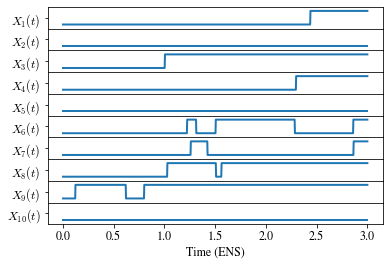

In [322]:
init_geno = np.eye(K)[np.zeros(L).astype(np.int)] # Initial genotype
g_t = evolve_genotype(init_geno)
g_t = np.array([np.where(g_t[i])[1] for i in range(len(g_t))])
plot_genotype(g_t)

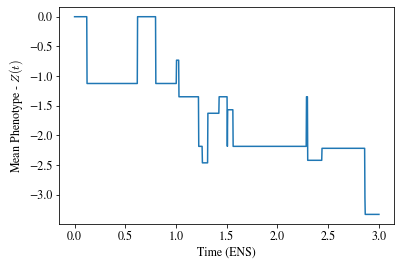

In [323]:
plot_phenotype(g_t, beta)

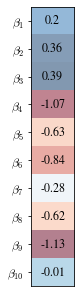

In [261]:
plt.figure(figsize=(1, 4))
plt.imshow(beta[:, 1:], cmap='RdBu', alpha=0.5, aspect='auto')
plt.xticks([])
plt.yticks(np.arange(L), ['$\\beta_{%d}$' % (i + 1) for i in range(L)])
for j in range(len(beta)):
    text = plt.text(0, j, np.round(beta[j, 1], 2),
                   ha="center", va="center", color="black")
plt.tight_layout(pad=0.2)
plt.savefig("./appendix_vis/fig1_b.svg")

# Moments of Mean Phenotype

In [376]:
n_replicates=100

#init_geno = np.eye(K)[np.random.choice(2, size=L, p=[0.9, 0.1]).astype(np.int)] # Initial genotype
init_geno = np.eye(K)[np.array([1, 1, 1, 0, 0, 0, 0, 0, 0, 0])]

res = []

for _ in  range(n_replicates):
    gt = evolve_genotype(init_geno)
    res.append(np.array([np.where(gt[i])[1] for i in range(len(gt))]))


<Figure size 432x288 with 0 Axes>

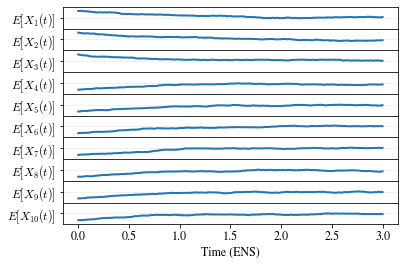

In [390]:
expected_genotype = np.zeros_like(res[0])
for i in range(n_replicates):
    expected_genotype += res[i]
    
plot_genotype(expected_genotype / n_replicates, fig_file="./appendix_vis/fig3a.svg", expectation=True)

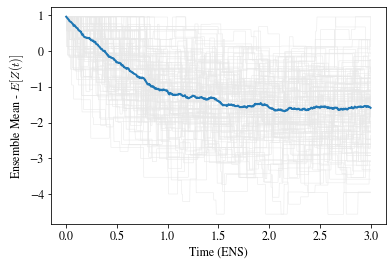

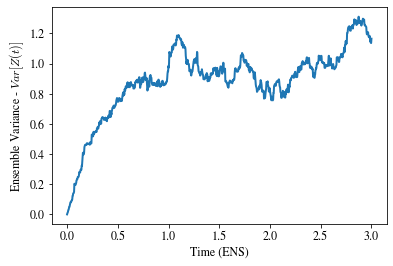

In [389]:
plot_ensemble_moments(res, beta, mean_fig_file="./appendix_vis/fig3b.svg", var_fig_file="./appendix_vis/fig3c.svg")

In [1]:
from Bio import Phylo
import pandas as pd
import numpy as np
from gp_models.gp_models import GaussianProcessModel, NeutralModel, OU, BM
%load_ext autoreload
%autoreload 2

In [19]:
erv_data = pd.read_csv("ancient_erv_analysis/data/3_q_traits/2_simulated_sequences/segment_7916_8695/traits.csv", index_col=0).T
erv_tree = Phylo.read("ancient_erv_analysis/metadata/segment_trees/paml_inferred/segment_7916_8695.nwk", "newick")

nm = NeutralModel(erv_data['gc_content'], erv_tree, fixed_params={'u': 1.37, 'Zeq': 0.36, 'sigma_eq': 0.000288})
nm.fit()

{'Optimization': {'Success': True,
  'Message': b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'},
 'Loglikelihood': 131.79868019120283,
 'DOF': 2,
 'AIC': -259.59736038240567,
 'AIC.c': -259.27303605808135,
 'BIC': -256.2196014741778,
 'Parameters': {'Z0': 0.45064921905129823,
  'Zeq': 0.36,
  'Psi': 0.001466726654975338,
  'sigma_eq': 0.000288,
  'u': 1.37}}

In [36]:
nm = NeutralModel(erv_data['gc_content'], erv_tree, fixed_params={'u': 1.34, 'Zeq': 0.44, 'sigma_eq': 0.00031})
nm.fit()

{'Optimization': {'Success': True,
  'Message': b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'},
 'Loglikelihood': 133.3038790819269,
 'DOF': 2,
 'AIC': -262.6077581638538,
 'AIC.c': -262.2834338395295,
 'BIC': -259.22999925562596,
 'Parameters': {'Z0': 0.4286605308041588,
  'Zeq': 0.44,
  'Psi': 0.0013519381029283538,
  'sigma_eq': 0.00031,
  'u': 1.34}}

In [37]:
nm = NeutralModel(erv_data['gc_content'], erv_tree, fixed_params={'u': 1.34})
nm.fit()

{'Optimization': {'Success': True,
  'Message': b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'},
 'Loglikelihood': 134.25707429348367,
 'DOF': 4,
 'AIC': -260.51414858696734,
 'AIC.c': -259.37129144411017,
 'BIC': -253.7586307705116,
 'Parameters': {'Z0': 0.4297984876708193,
  'Zeq': 0.4359537231454264,
  'Psi': 9.99999997437784e-13,
  'sigma_eq': 0.0025563088548873187,
  'u': 1.34}}

In [38]:
nm = NeutralModel(erv_data['gc_content'], erv_tree)
nm.fit()

{'Optimization': {'Success': True,
  'Message': b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'},
 'Loglikelihood': 134.90977876586916,
 'DOF': 5,
 'AIC': -259.8195575317383,
 'AIC.c': -258.0548516493854,
 'BIC': -251.37516026116865,
 'Parameters': {'Z0': 0.4298567820580272,
  'Zeq': 0.4341898649481175,
  'Psi': 9.999999960041972e-13,
  'sigma_eq': 0.0012508851221227223,
  'u': 2.0}}

In [41]:
ou = OU(erv_data['gc_content'], erv_tree)
ou.fit()

{'Optimization': {'Success': True,
  'Message': b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'},
 'Loglikelihood': 139.7563195304113,
 'DOF': 4,
 'AIC': -271.5126390608226,
 'AIC.c': -270.36978191796544,
 'BIC': -264.7571212443669,
 'Parameters': {'Z0': 0.4294136384780781,
  'Zeq': 0.4320629759227744,
  'sigma': 0.003293928936528404,
  'alpha': 18.468859845082363}}

In [44]:
ou = OU(erv_data['gc_content'], erv_tree, equilibrium_z0=True)
ou.fit()

{'Optimization': {'Success': True,
  'Message': b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'},
 'Loglikelihood': 139.7548962775069,
 'DOF': 3,
 'AIC': -273.5097925550138,
 'AIC.c': -272.8431258883471,
 'BIC': -268.443154192672,
 'Parameters': {'Zeq': 0.43201396720676144,
  'sigma': 0.003283819918767566,
  'alpha': 18.382295122779674}}

In [43]:
bm = BM(erv_data['gc_content'], erv_tree)
bm.fit()

{'Optimization': {'Success': True,
  'Message': b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'},
 'Loglikelihood': 131.68912822706005,
 'DOF': 2,
 'AIC': -259.3782564541201,
 'AIC.c': -259.0539321297958,
 'BIC': -256.00049754589224,
 'Parameters': {'Z0': 0.43090571681745277, 'sigma': 0.0015004967278711004}}

In [169]:
import sys
sys.path.insert(0, "ancient_erv_analysis")
from compute_q_traits import calculate_gc_content

def plot_nll(segment):

    erv_data = pd.read_csv(f"ancient_erv_analysis/data/3_q_traits/2_simulated_sequences/{segment}/traits.csv", index_col=0).T
    erv_tree = Phylo.read(f"ancient_erv_analysis/metadata/segment_trees/paml_inferred/{segment}.nwk", "newick")
    
    with open(f"ancient_erv_analysis/data/2_simulated_sequences/{segment}/alignment.root", "r") as algn_f:
        root_seq = str(algn_f.read()).strip()
        
    true_z0 = calculate_gc_content(root_seq)
    
    nm = NeutralModel(erv_data['gc_content'], erv_tree, fixed_params={'u': 1.34, 'Zeq': 0.44, 'sigma_eq': 0.2464/len(root_seq)})
    nm.fit()

    z0 = np.linspace(0., 1., 100)
    L = 800

    psi = (1./L)*(0.44 + z0 -2.*z0*0.44)

    nll = []

    for i in range(100):
        nm.z0 = z0[i]
        nm.psi = psi[i]
        nll.append(nm.nll())

    plt.plot(z0, nll)
    plt.axvline(true_z0, c='red', ls='--', label='True Z0')
    plt.xlabel("Z0")
    plt.ylabel("NLL")
    plt.title(f"GC Content - {segment}")
    plt.legend()
    plt.show()

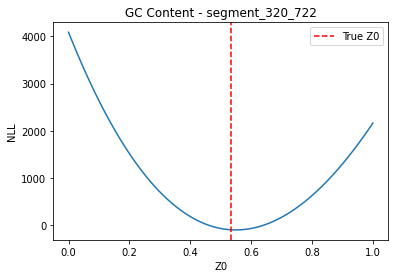

In [171]:
plot_nll('segment_320_722')

In [161]:
res_geiger = pd.read_csv("ancient_erv_analysis/geiger_inference/Simulated Sequences.csv", index_col=0)
res_python = pd.read_csv("gp_models/model_fit_results/simulated_seq_paml_inf_tree.csv", index_col=0)
res_ouch = pd.read_csv("ancient_erv_analysis/ouch_inference/Simulated Sequences.csv", index_col=0)

In [162]:
res_python = res_python.loc[res_python['Model'].isin(['BM', 'OU (Z0=Zeq)']), ['Trait', 'Sequence', 'Model', 'Log-likelihood', 'Corrected AIC', 'Z0']]

res_python['Trait'] = res_python['Trait'].replace({'gc_content': 'GC Content', 'A_percent':'Percent of A', 
                       'longest_ORF': 'Longest ORF', 'longest_ORF_alan': 'Longest ORF (Alan)'})
res_python['Model'] = res_python['Model'].replace({'OU (Z0=Zeq)': 'OU'})
res_python.columns = ['trait', 'segment', 'Model', 'loglik', 'aicc', 'z0']

res_python=pd.DataFrame(res_python.pivot(index=['trait','segment'], columns='Model', values=['loglik', 'aicc', 'z0']).to_records())
res_python.columns=['trait', 'segment', 'BM_loglik', 'OU_loglik', 'BM_aicc', 'OU_aicc', 'BM_z0', 'OU_z0']
res_python = res_python.sort_values(['segment', 'trait'])
res_python

trait              segment  ...       BM_z0      OU_z0
0           GC Content  segment_10270_10563  ...    0.445244   0.446803
6          Longest ORF  segment_10270_10563  ...    0.239975   0.198909
12  Longest ORF (Alan)  segment_10270_10563  ...   64.831010  43.895667
18        Percent of A  segment_10270_10563  ...    0.255779   0.259193
1           GC Content  segment_11196_11705  ...    0.405969   0.421714
7          Longest ORF  segment_11196_11705  ...    0.162359   0.141444
13  Longest ORF (Alan)  segment_11196_11705  ...   69.251633  57.071273
19        Percent of A  segment_11196_11705  ...    0.276056   0.271804
2           GC Content  segment_11935_12275  ...    0.479073   0.482101
8          Longest ORF  segment_11935_12275  ...    0.193667   0.196897
14  Longest ORF (Alan)  segment_11935_12275  ...  241.633075  43.028640
20        Percent of A  segment_11935_12275  ...    0.252608   0.256327
3           GC Content      segment_320_722  ...    0.533303   0.532534
9          Longest ORF      segment_320_722  ...    0.226049   0.205362
15  Longest ORF (Alan)      segment_320_722  ...   50.914170  54.564761
21        Percent of A      segment_320_722  ...    0.217699   0.241126
4           GC Content    segment_7916_8695  ...    0.430906   0.432014
10         Longest ORF    segment_7916_8695  ...    0.099697   0.103095
16  Longest ORF (Alan)    segment_7916_8695  ...   59.929494  53.178721
22        Percent of A    segment_7916_8695  ...    0.276735   0.276735
5           GC Content    segment_8938_9248  ...    0.347892   0.372576
11         Longest ORF    segment_8938_9248  ...    0.194825   0.195943
17  Longest ORF (Alan)    segment_8938_9248  ...   42.947903  41.672002
23        Percent of A    segment_8938_9248  ...    0.347314   0.326215

[24 rows x 8 columns]

In [163]:
res_geiger = res_geiger[['trait', 'segment', 'BM_loglik', 'OU_loglik', 'BM_aicc', 'OU_aicc', 'BM_z0', 'OU_z0']]
res_geiger = res_geiger.sort_values(['segment', 'trait'])
res_geiger

trait              segment   BM_loglik  ...     OU_aicc      BM_z0      OU_z0
1           GC Content  segment_10270_10563  117.052026  ... -227.606502   0.445244   0.446803
2          Longest ORF  segment_10270_10563   64.678852  ... -143.081174   0.239975   0.198909
4   Longest ORF (Alan)  segment_10270_10563 -152.442321  ...  300.953112  64.830701  43.896081
3         Percent of A  segment_10270_10563  122.320980  ... -239.962714   0.255779   0.259193
5           GC Content  segment_11196_11705  120.667773  ... -246.573924   0.405969   0.421714
6          Longest ORF  segment_11196_11705   37.044146  ... -147.724006   0.162359   0.141446
8   Longest ORF (Alan)  segment_11196_11705 -204.000881  ...  341.779447  69.223404  57.081638
7         Percent of A  segment_11196_11705  132.446367  ... -272.657660   0.276056   0.271803
9           GC Content  segment_11935_12275   99.900996  ... -224.479250   0.479073   0.482101
10         Longest ORF  segment_11935_12275   22.265511  ... -137.773740   0.193631   0.196895
12  Longest ORF (Alan)  segment_11935_12275 -202.235630  ...  290.022472  50.995818  49.012714
11        Percent of A  segment_11935_12275   83.898207  ... -218.973969   0.252608   0.256328
13          GC Content      segment_320_722  110.500100  ... -214.428290   0.533303   0.493805
14         Longest ORF      segment_320_722   54.691304  ... -129.063689   0.226049   0.205363
16  Longest ORF (Alan)      segment_320_722 -185.123044  ...  341.699316  51.238445  54.553369
15        Percent of A      segment_320_722   85.029930  ... -203.862245   0.217699   0.241125
17          GC Content    segment_7916_8695  131.689128  ... -272.843126   0.430906   0.432014
18         Longest ORF    segment_7916_8695  101.529044  ... -198.691249   0.099697   0.103092
20  Longest ORF (Alan)    segment_7916_8695 -178.665196  ...  348.188508  59.944956  53.210739
19        Percent of A    segment_7916_8695  148.515794  ... -302.225298   0.276735   0.278200
21          GC Content    segment_8938_9248   98.439445  ... -211.069357   0.347892   0.372578
22         Longest ORF    segment_8938_9248   76.725661  ... -157.753848   0.194825   0.195944
24  Longest ORF (Alan)    segment_8938_9248 -231.780087  ...  280.791471  41.542907  38.571874
23        Percent of A    segment_8938_9248  104.026755  ... -218.744568   0.347314   0.326216

[24 rows x 8 columns]

In [164]:
res_ouch.columns = ['segment', 'trait', 'BM_loglik_ouch', 'BM_aicc_ouch', 'BM_z0_ouch', 'OU_loglik_ouch',
       'OU_aicc_ouch', 'OU_z0_ouch']
res_ouch = res_ouch[['trait', 'segment', 'BM_loglik_ouch', 'OU_loglik_ouch', 'BM_aicc_ouch', 
                     'OU_aicc_ouch', 'BM_z0_ouch', 'OU_z0_ouch']]
res_ouch = res_ouch.sort_values(['segment', 'trait'])
res_ouch

trait              segment  ...  BM_z0_ouch  OU_z0_ouch
1           GC Content  segment_10270_10563  ...    0.458465    0.440455
2          Longest ORF  segment_10270_10563  ...    0.163735    0.197643
4   Longest ORF (Alan)  segment_10270_10563  ...   36.024982   44.318450
3         Percent of A  segment_10270_10563  ...    0.251700    0.263966
5           GC Content  segment_11196_11705  ...    0.430227    0.422105
6          Longest ORF  segment_11196_11705  ...    0.172103    0.142000
8   Longest ORF (Alan)  segment_11196_11705  ...   78.366284   58.089240
7         Percent of A  segment_11196_11705  ...    0.276225    0.268811
9           GC Content  segment_11935_12275  ...    0.474791    0.481097
10         Longest ORF  segment_11935_12275  ...    0.169434    0.197115
12  Longest ORF (Alan)  segment_11935_12275  ...   51.424995   48.815332
11        Percent of A  segment_11935_12275  ...    0.269822    0.256949
13          GC Content      segment_320_722  ...    0.507785    0.492857
14         Longest ORF      segment_320_722  ...    0.167240    0.207496
16  Longest ORF (Alan)      segment_320_722  ...   48.927910   62.455679
15        Percent of A      segment_320_722  ...    0.221977    0.241509
17          GC Content    segment_7916_8695  ...    0.427487    0.435183
18         Longest ORF    segment_7916_8695  ...    0.081964    0.101296
20  Longest ORF (Alan)    segment_7916_8695  ...   46.922558   48.637574
19        Percent of A    segment_7916_8695  ...    0.280382    0.278740
21          GC Content    segment_8938_9248  ...    0.355907    0.375363
22         Longest ORF    segment_8938_9248  ...    0.183278    0.189538
24  Longest ORF (Alan)    segment_8938_9248  ...   47.020328   38.810604
23        Percent of A    segment_8938_9248  ...    0.336190    0.325553

[24 rows x 8 columns]

In [211]:
m_res = pd.merge(res_geiger, res_python, on=['trait', 'segment'], suffixes=('_geiger', '_python')).merge(res_ouch, on=['trait', 'segment'])
comp_res = m_res[['trait', 'segment'] + sorted(m_res.columns[2:])] 
comp_res.to_csv("comparison_table.csv", index=False)
comp_res

trait              segment  ...  OU_z0_ouch  OU_z0_python
0           GC Content  segment_10270_10563  ...    0.440455      0.446803
1          Longest ORF  segment_10270_10563  ...    0.197643      0.198909
2   Longest ORF (Alan)  segment_10270_10563  ...   44.318450     43.895667
3         Percent of A  segment_10270_10563  ...    0.263966      0.259193
4           GC Content  segment_11196_11705  ...    0.422105      0.421714
5          Longest ORF  segment_11196_11705  ...    0.142000      0.141444
6   Longest ORF (Alan)  segment_11196_11705  ...   58.089240     57.071273
7         Percent of A  segment_11196_11705  ...    0.268811      0.271804
8           GC Content  segment_11935_12275  ...    0.481097      0.482101
9          Longest ORF  segment_11935_12275  ...    0.197115      0.196897
10  Longest ORF (Alan)  segment_11935_12275  ...   48.815332     43.028640
11        Percent of A  segment_11935_12275  ...    0.256949      0.256327
12          GC Content      segment_320_722  ...    0.492857      0.532534
13         Longest ORF      segment_320_722  ...    0.207496      0.205362
14  Longest ORF (Alan)      segment_320_722  ...   62.455679     54.564761
15        Percent of A      segment_320_722  ...    0.241509      0.241126
16          GC Content    segment_7916_8695  ...    0.435183      0.432014
17         Longest ORF    segment_7916_8695  ...    0.101296      0.103095
18  Longest ORF (Alan)    segment_7916_8695  ...   48.637574     53.178721
19        Percent of A    segment_7916_8695  ...    0.278740      0.276735
20          GC Content    segment_8938_9248  ...    0.375363      0.372576
21         Longest ORF    segment_8938_9248  ...    0.189538      0.195943
22  Longest ORF (Alan)    segment_8938_9248  ...   38.810604     41.672002
23        Percent of A    segment_8938_9248  ...    0.325553      0.326215

[24 rows x 20 columns]

# Plotting results

In [333]:
df = pd.read_csv("gp_models/model_fit_results/simulated_seq_paml_inf_tree.csv", index_col=0)
df = df.loc[df['Trait'] != 'longest_ORF_alan']
df['True Zeq'] = df['Trait'].map({'gc_content': .44, 'A_percent': .28})
df['Absolute Relative Error (Zeq)'] = np.abs((df['Zeq'] - df['True Zeq']) / df['True Zeq'])
df['Absolute Relative Error'] = np.abs((df['Z0'] - df['True Z0']) / df['True Z0'])
df['Relative Error']= (df['Z0'] - df['True Z0']) / df['True Z0']
df

Trait           Sequence  ... Absolute Relative Error  Relative Error
0    gc_content  segment_8938_9248  ...                0.005616        0.005616
1    gc_content  segment_8938_9248  ...                0.050191       -0.050191
2    gc_content  segment_8938_9248  ...                0.016583        0.016583
3    gc_content  segment_8938_9248  ...                0.015814        0.015814
4    gc_content  segment_8938_9248  ...                1.349022       -1.349022
..          ...                ...  ...                     ...             ...
134   A_percent  segment_7916_8695  ...                0.021073       -0.021073
135   A_percent  segment_7916_8695  ...                0.013867       -0.013867
136   A_percent  segment_7916_8695  ...                0.009846       -0.009846
137   A_percent  segment_7916_8695  ...                0.009846       -0.009846
138   A_percent  segment_7916_8695  ...                0.009847       -0.009847

[114 rows x 14 columns]

In [332]:
df['Trait'].map({'gc_content': .44, 'A_percent': .28})

0      0.44
1      0.44
2      0.44
3      0.44
4      0.44
       ... 
134    0.28
135    0.28
136    0.28
137    0.28
138    0.28
Name: Trait, Length: 114, dtype: float64

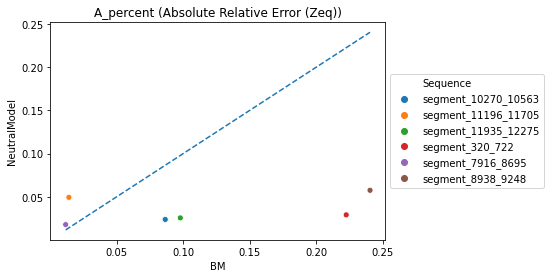

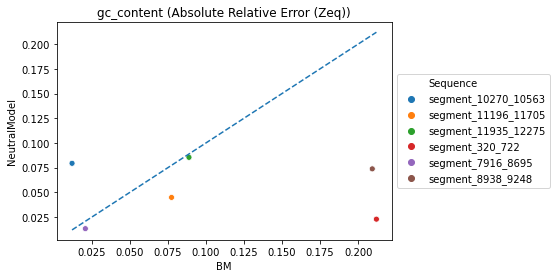

No handles with labels found to put in legend.


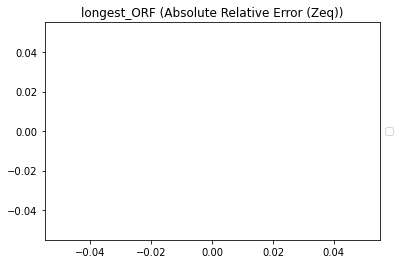

In [335]:
metric = 'Absolute Relative Error (Zeq)'

mdf = df.pivot(index=['Trait', 'Sequence'], columns='Model', values=metric).reset_index()

x_model = 'BM' #'OU (Z0=Zeq)'
y_model = 'NeutralModel'

for t in mdf['Trait'].unique():
    t_mdf = mdf.loc[mdf['Trait'] == t]
    ax = sns.scatterplot(data=t_mdf, x=x_model, y=y_model, hue="Sequence")
    x = np.linspace(t_mdf[[x_model, y_model]].min().min(), t_mdf[[x_model, y_model]].max().max(), 1000)
    plt.plot(x, x, ls='--')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(t + f' ({metric})')
    plt.show()

In [127]:
mdf['Trait'].unique()

array(['gc_content', 'longest_ORF', 'A_percent', 'longest_ORF_alan'],
      dtype=object)

Text(0.5, 1.0, 'Corrected AIC Difference with respect to OU')

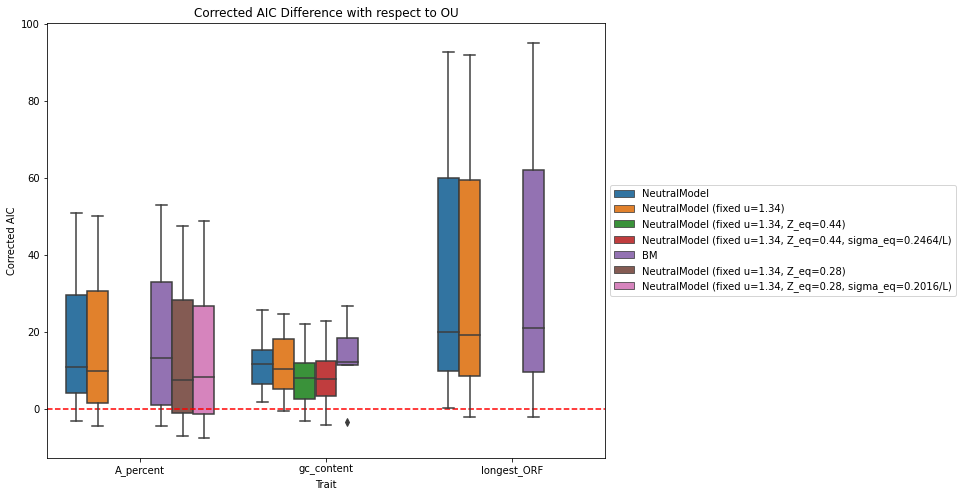

In [318]:
metric = 'Corrected AIC'
ref = 'OU'
exclude_models = ['OU (Z0=Zeq)']

mdf = df.pivot(index=['Trait', 'Sequence'], columns='Model', values=metric).reset_index()

for m in df['Model'].unique():
    if m != ref:
        mdf[m] -= mdf[ref]
        
melt_df = pd.melt(mdf, id_vars=('Trait', 'Sequence'),
                  value_vars=[m for m in df['Model'].unique() if m != ref and m not in exclude_models],
                  value_name=metric)

plt.figure(figsize=(10, 8))
ax = sns.boxplot(x="Trait", y=metric, hue="Model", data=melt_df)
plt.axhline(y=0., ls='--', c='r', zorder=1)
#plt.ylim([-.1, .1])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title(f'{metric} Difference with respect to {ref}')

In [636]:
res_df = pd.read_csv("simulation_analysis/data/inference_results.csv")
res_df

Trait  Simulation             BaseFreq  ...    Z0 RPD    Zeq SE   Zeq RPD
0       gc_content          97  0.28_0.22_0.22_0.28  ...  0.026099  0.002857 -0.129339
1       gc_content          97  0.28_0.22_0.22_0.28  ...  0.025855  0.000393 -0.046071
2       gc_content          97  0.28_0.22_0.22_0.28  ...  0.021054  0.000000  0.000000
3       gc_content          97  0.28_0.22_0.22_0.28  ...  0.063815  0.000034 -0.013292
4       gc_content          97  0.28_0.22_0.22_0.28  ...  0.000753  0.004954  0.148117
...            ...         ...                  ...  ...       ...       ...       ...
215995   A_percent          71  0.25_0.25_0.25_0.25  ...  2.000000  0.000588 -0.101950
215996   A_percent          71  0.25_0.25_0.25_0.25  ... -2.000000  0.000000  0.000000
215997   A_percent          71  0.25_0.25_0.25_0.25  ...  2.000000  0.005988 -0.366192
215998   A_percent          71  0.25_0.25_0.25_0.25  ...  2.000000  0.000723 -0.113645
215999   A_percent          71  0.25_0.25_0.25_0.25  ...  2.000000  0.000723 -0.113645

[216000 rows x 12 columns]

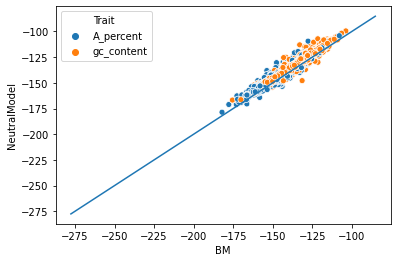

In [637]:
mdf = res_df.pivot(index=['BaseFreq','TVRatio','ScaleFactor','InitialSequence', 'Trait', 'Simulation'],
                   columns='Model', values='AICc').reset_index()

mdf = mdf.loc[mdf['Trait'] != 'gaussian_es_trait']

x = 'BM'
y = 'NeutralModel'

sns.scatterplot(data=mdf.loc[mdf['ScaleFactor'] == 20], x=x, y=y, hue='Trait')
lins = np.linspace(mdf[[x, y]].min().min(), mdf[[x, y]].max().max(), 1000)
plt.plot(lins, lins)

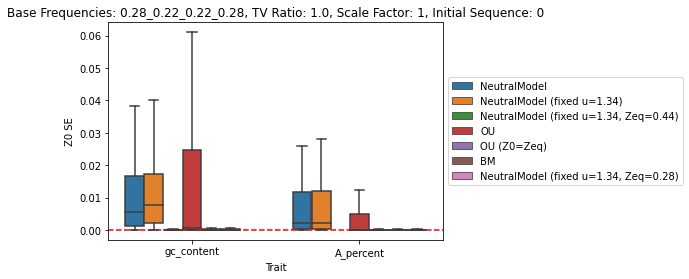

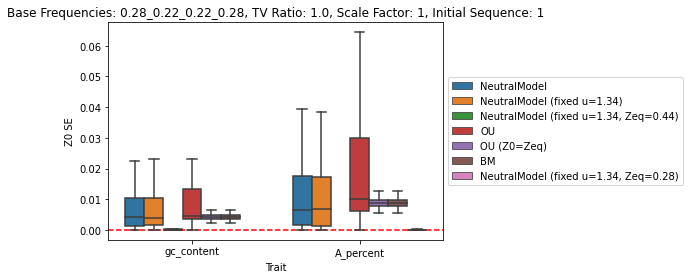

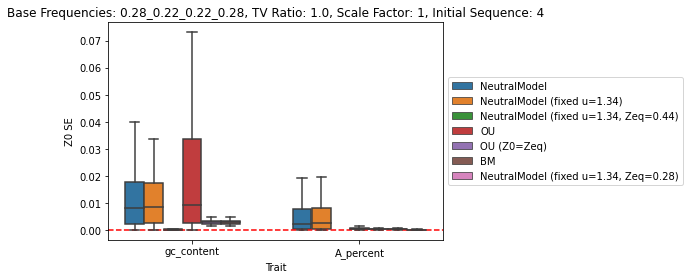

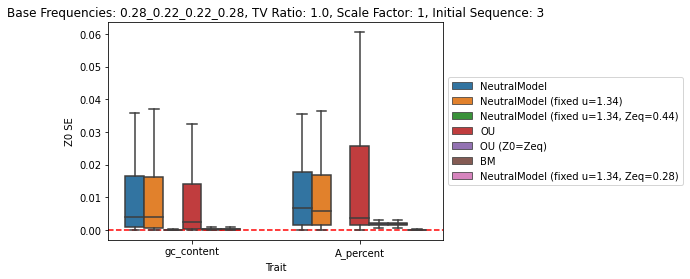

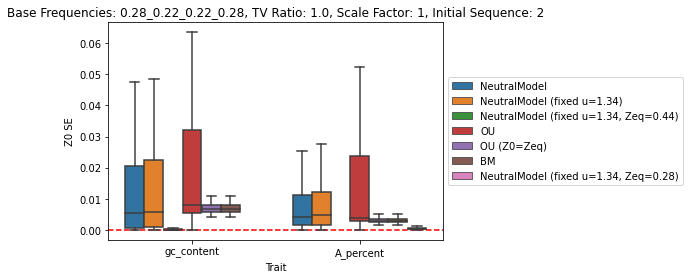

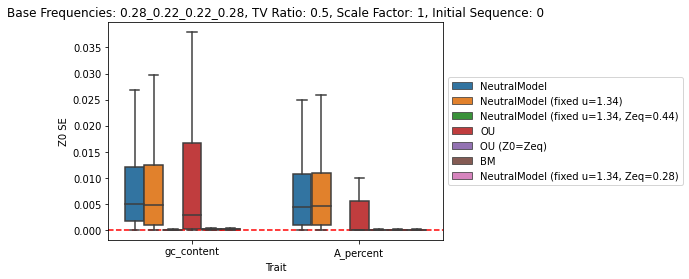

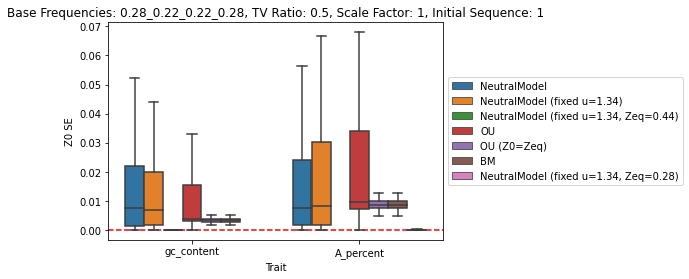

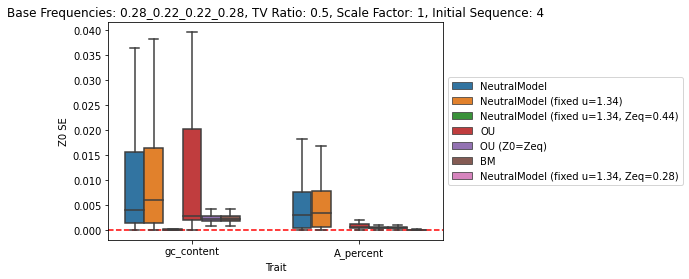

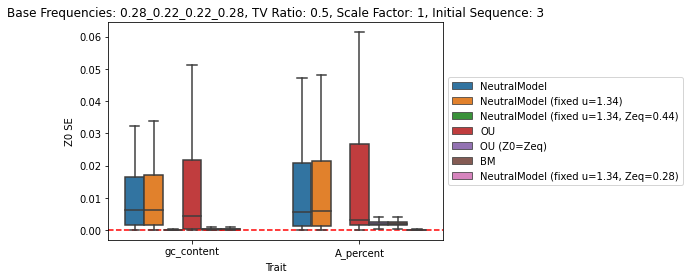

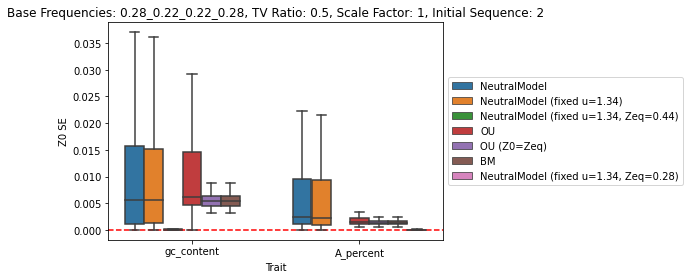

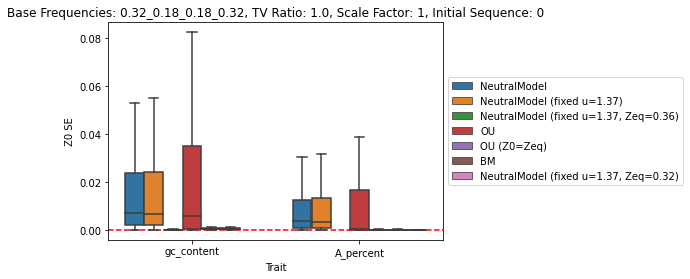

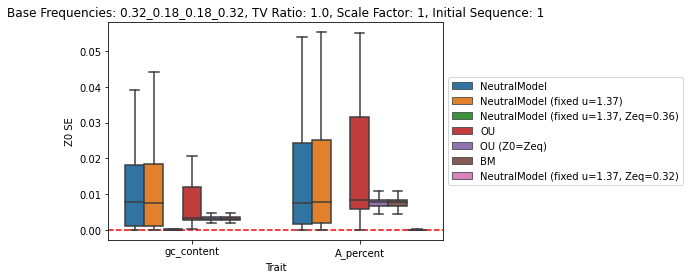

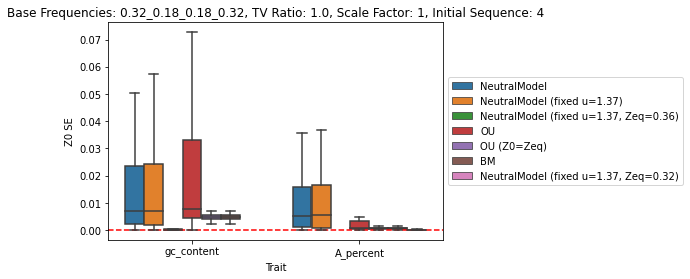

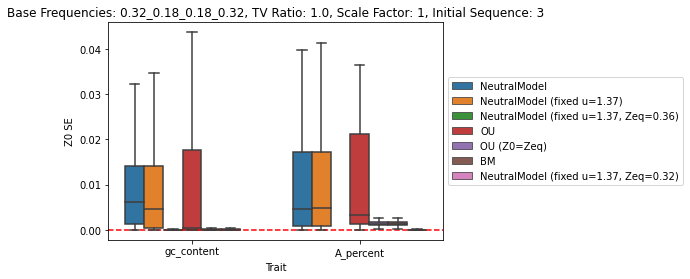

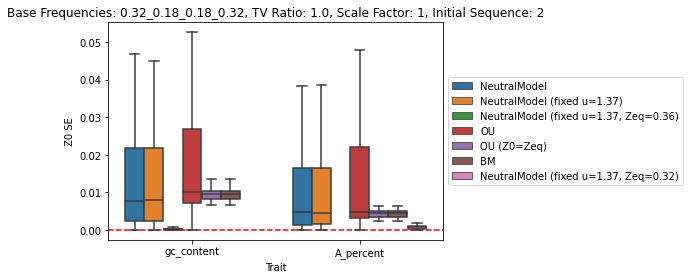

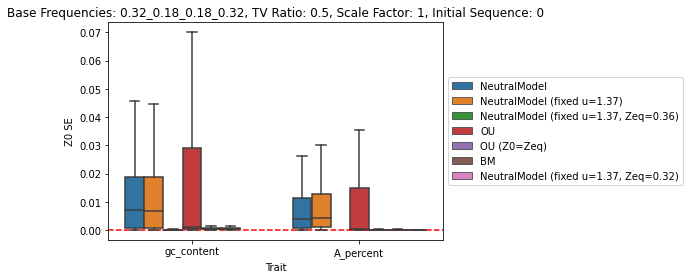

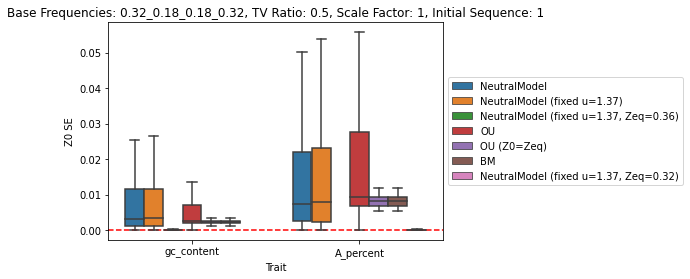

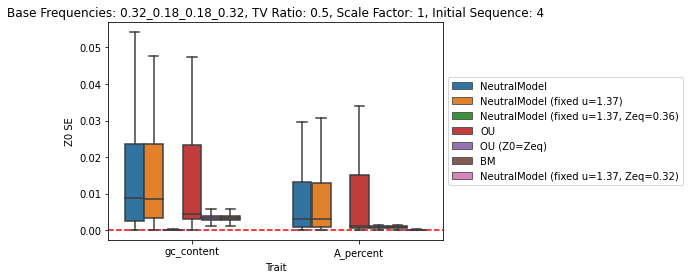

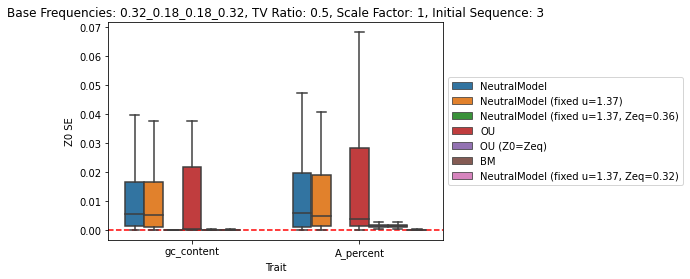

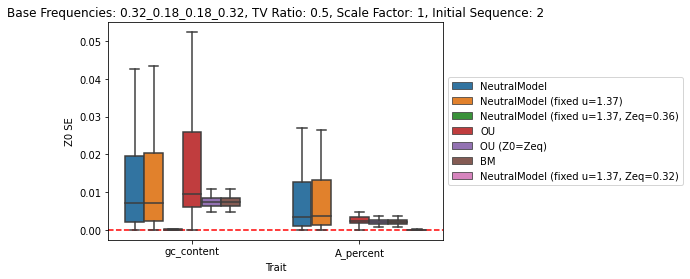

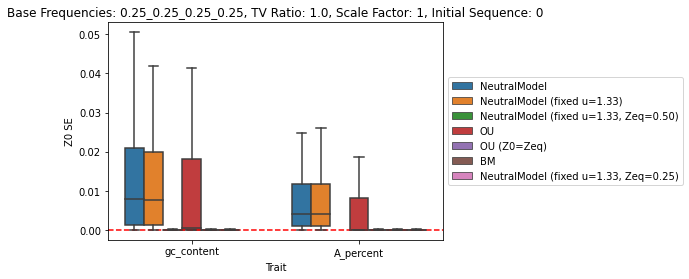

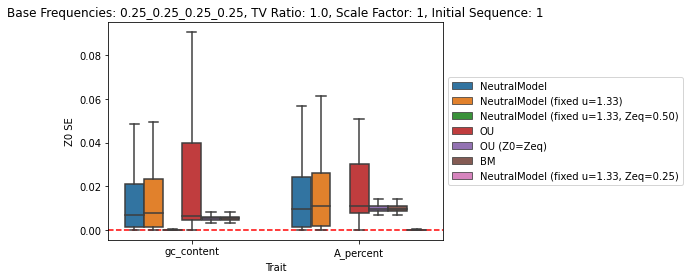

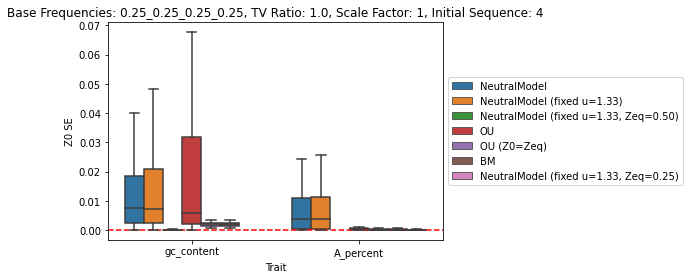

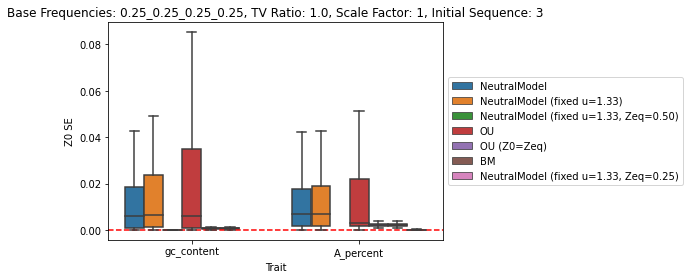

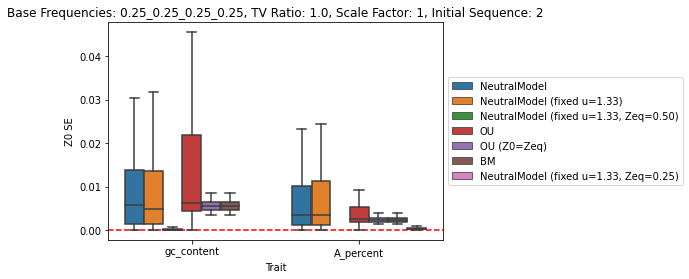

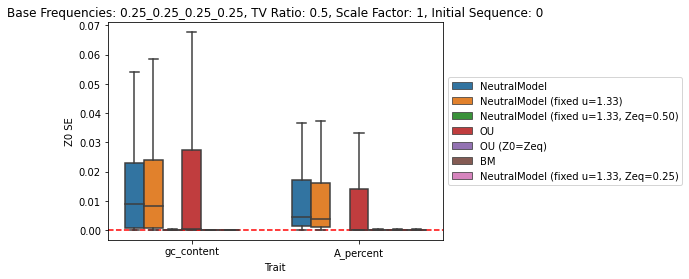

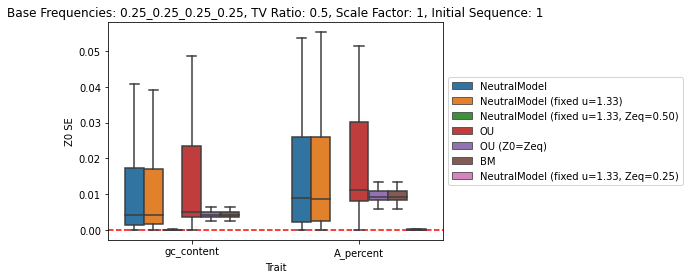

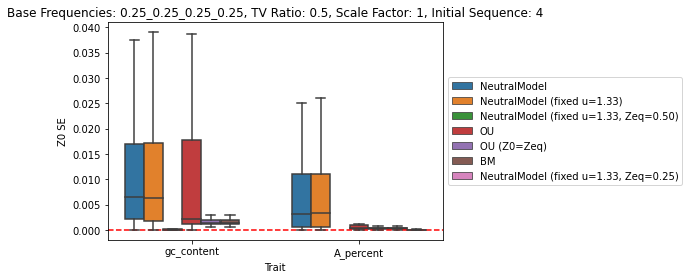

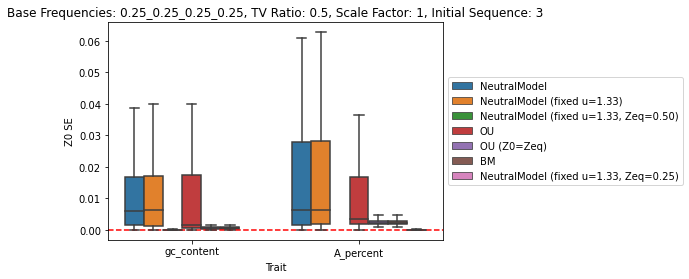

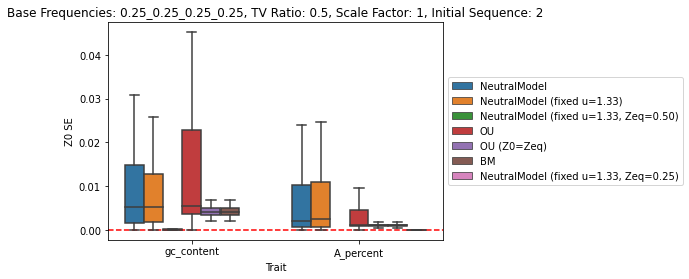

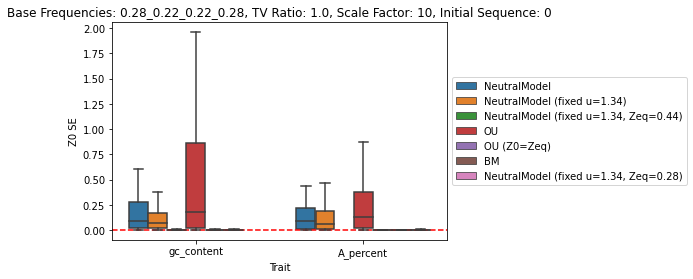

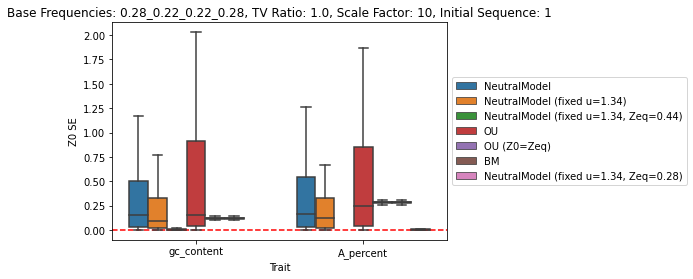

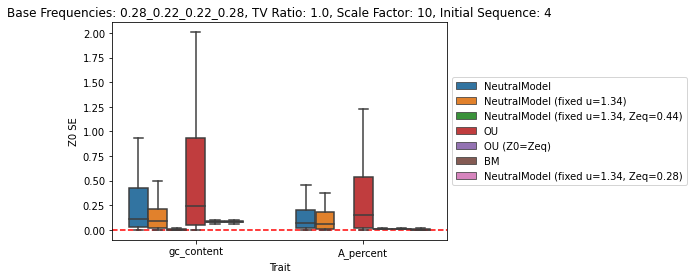

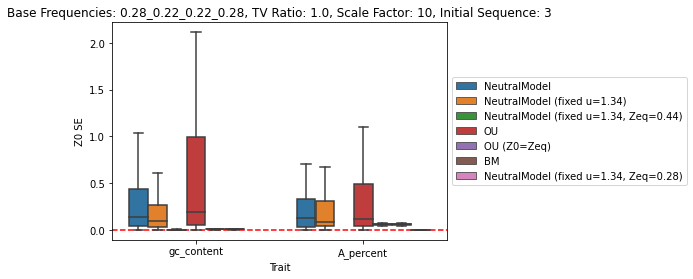

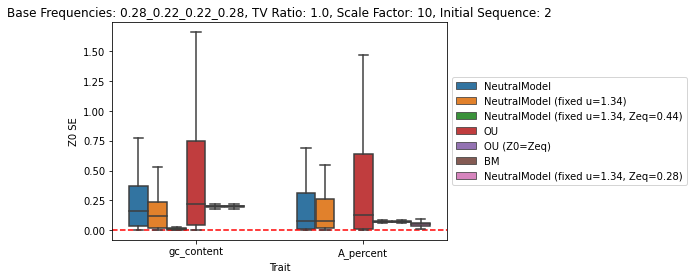

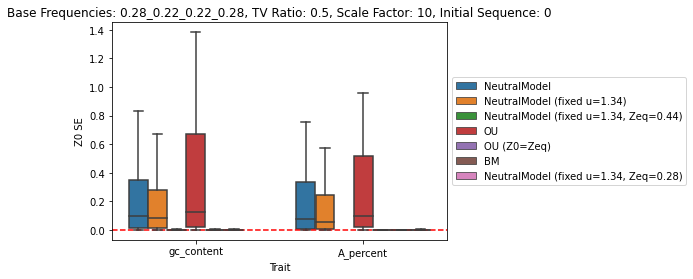

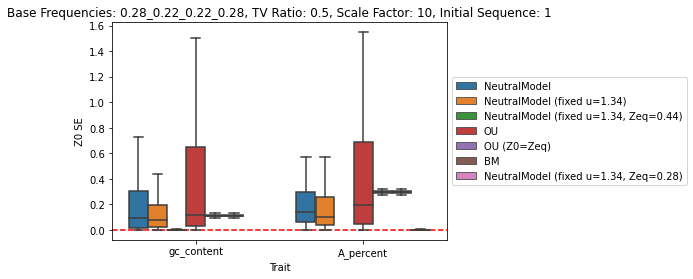

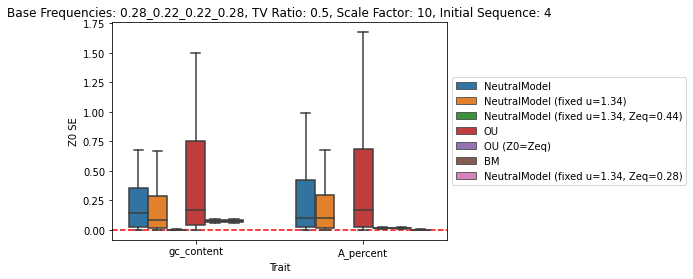

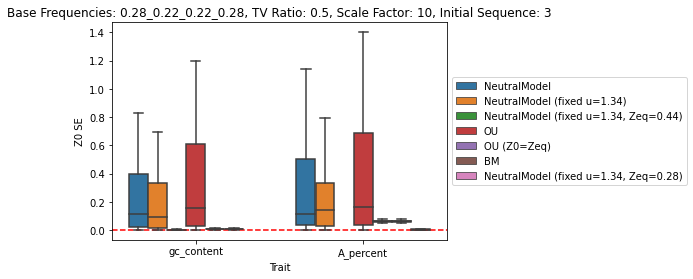

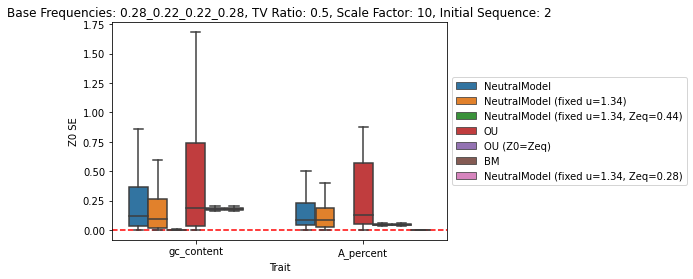

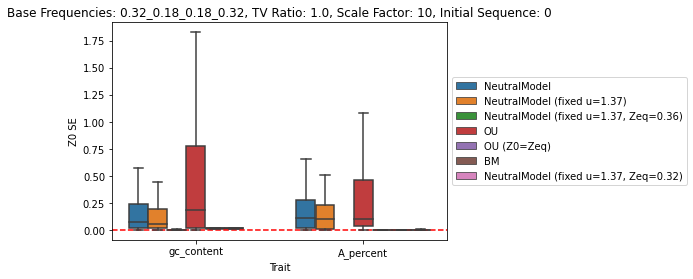

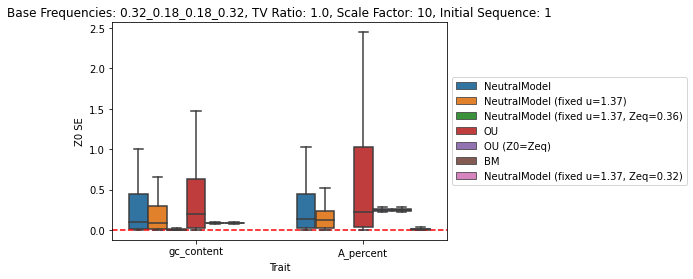

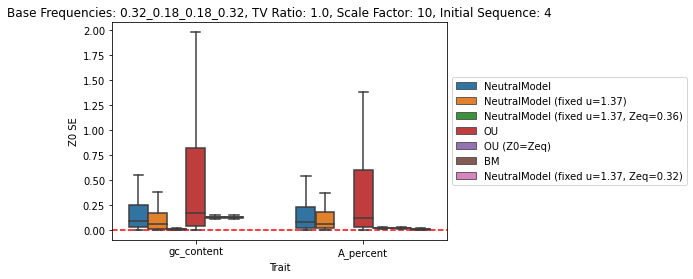

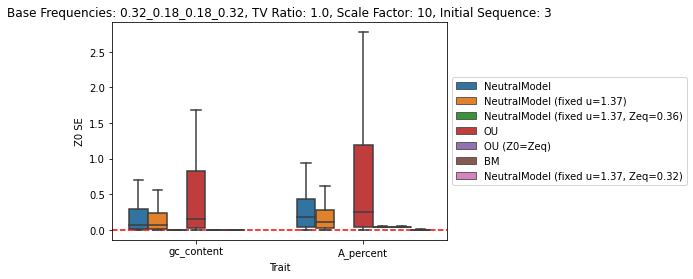

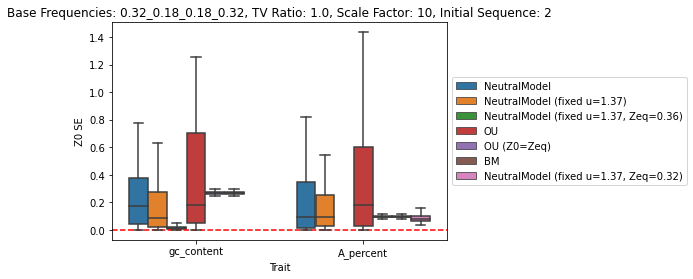

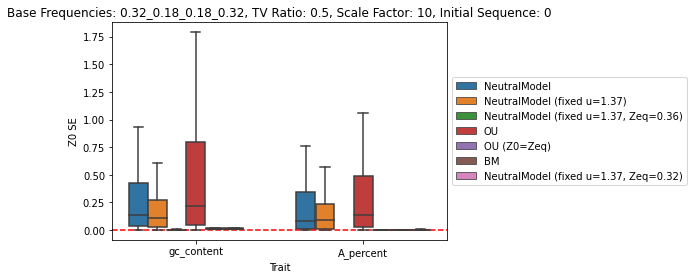

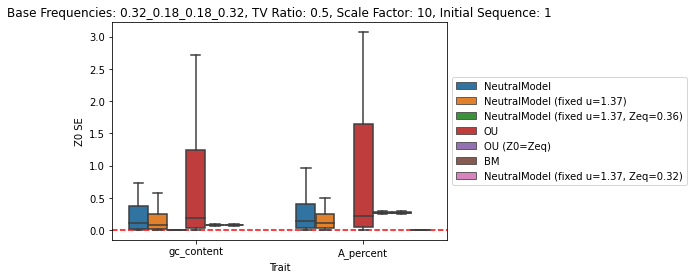

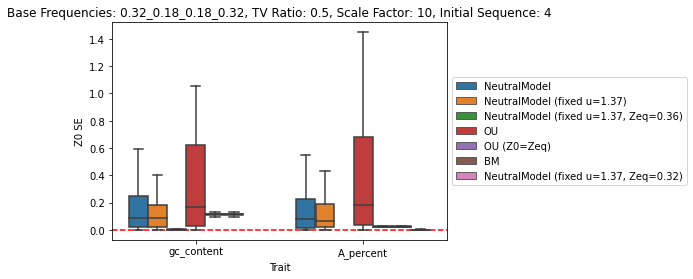

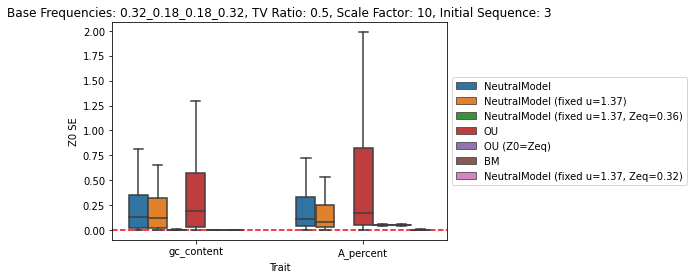

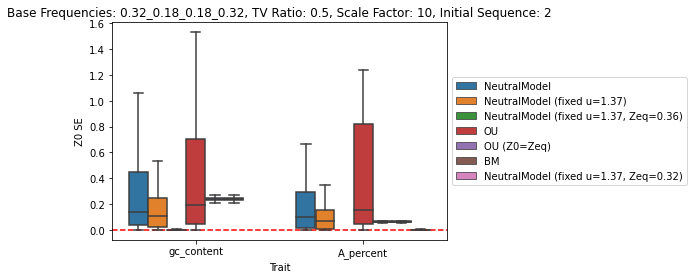

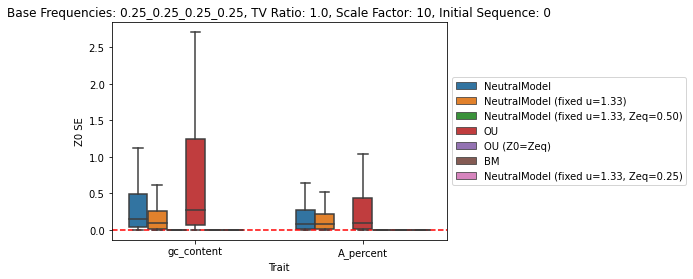

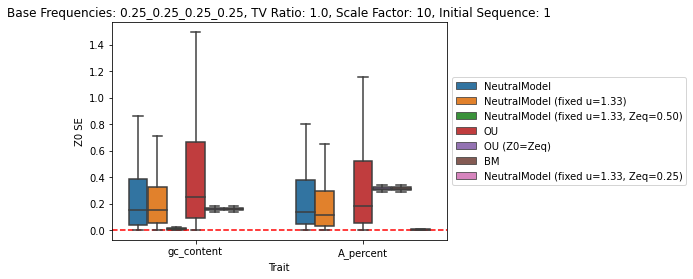

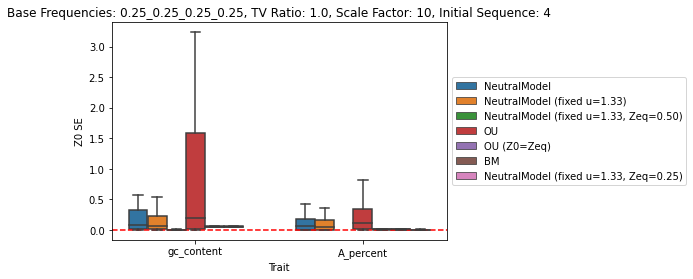

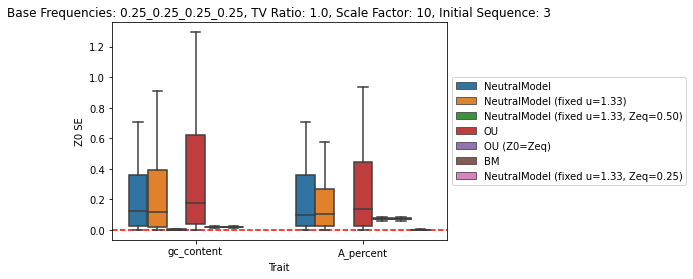

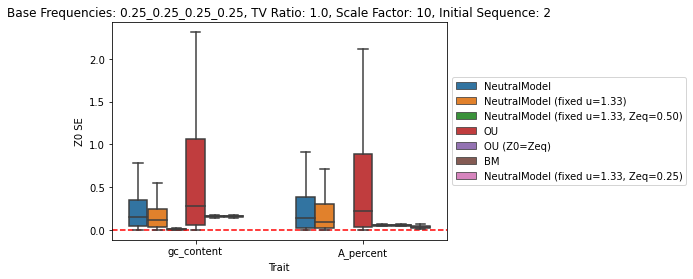

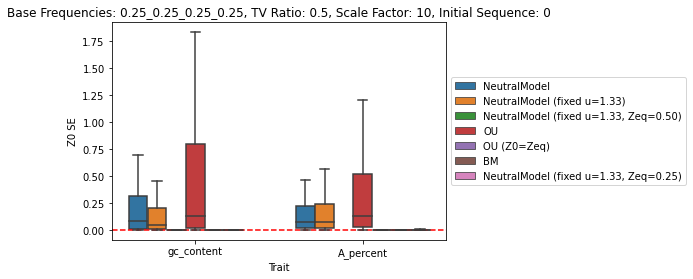

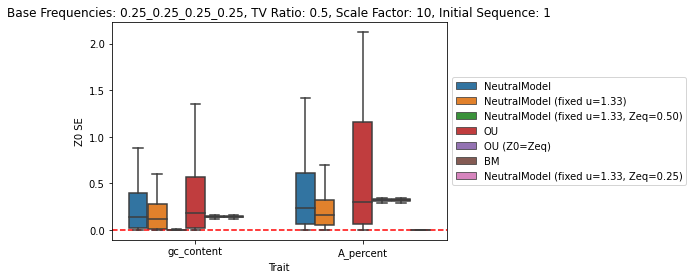

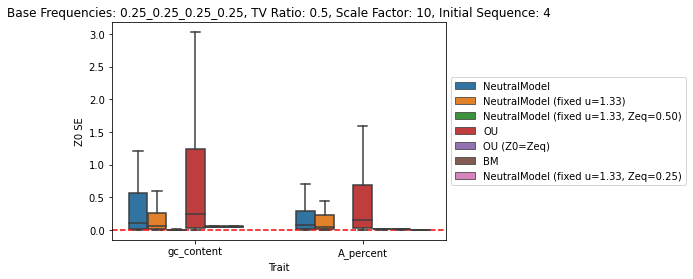

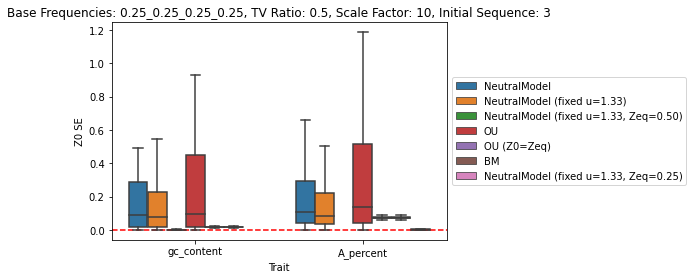

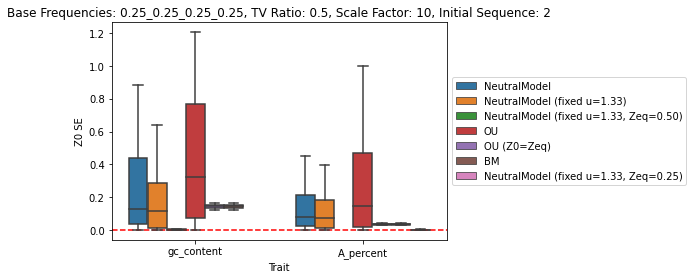

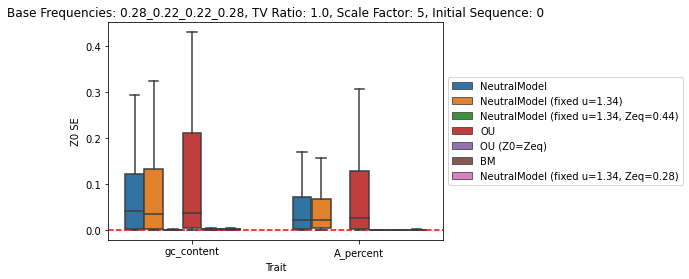

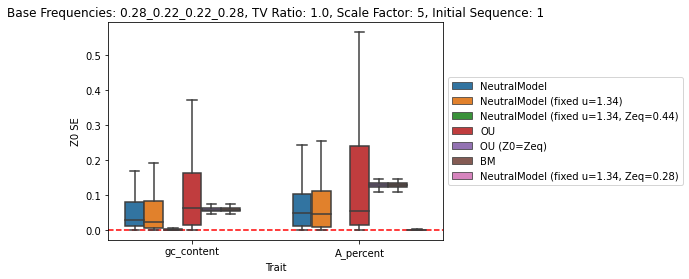

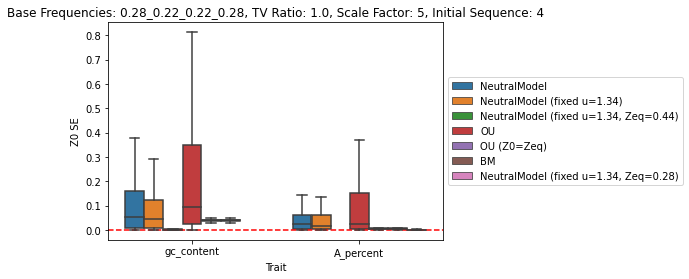

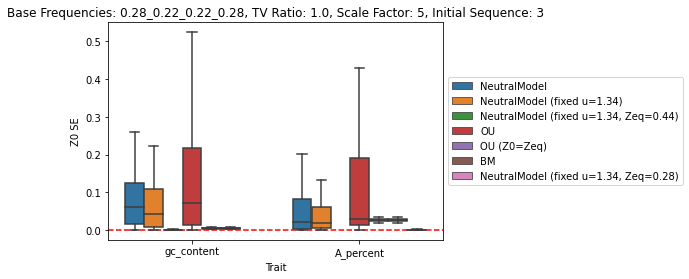

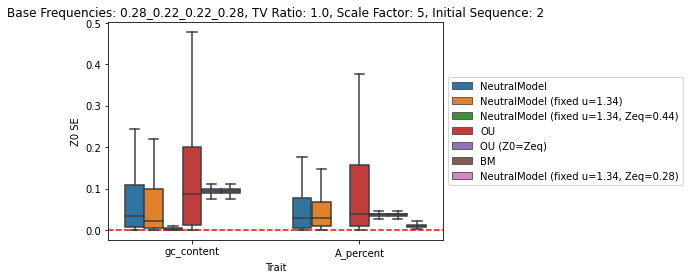

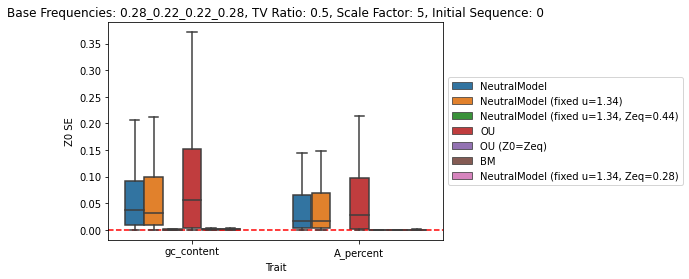

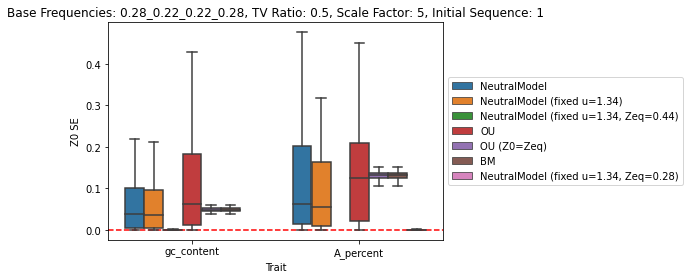

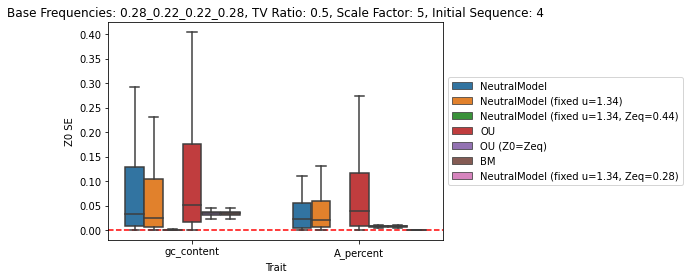

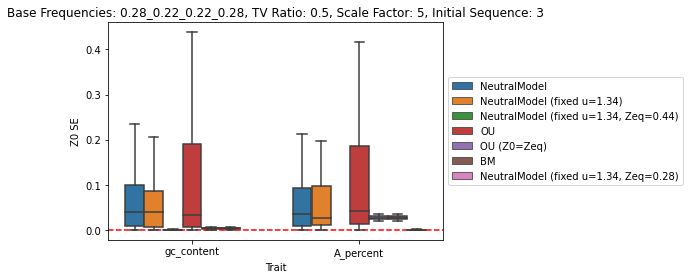

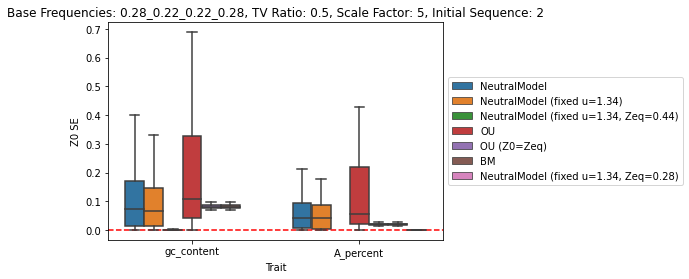

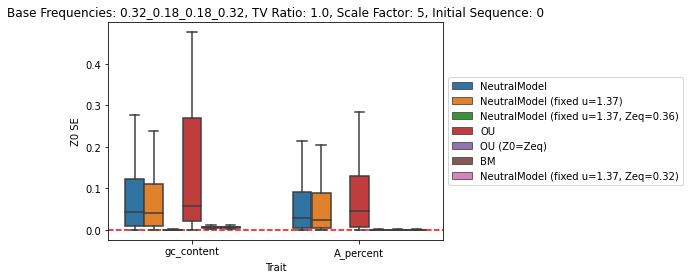

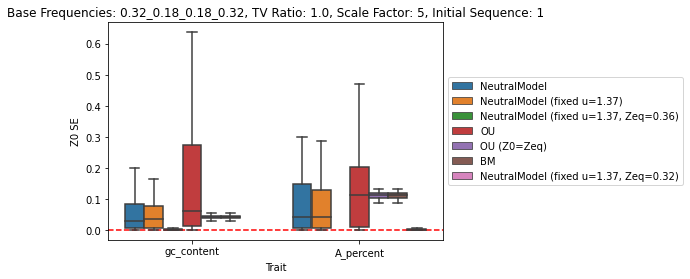

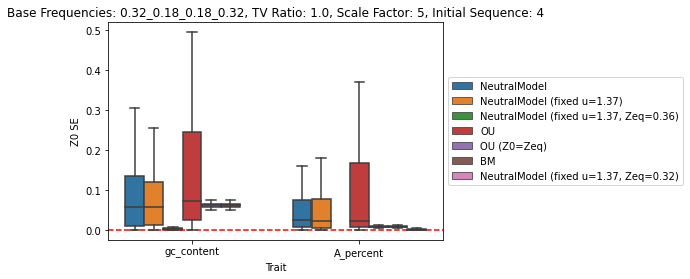

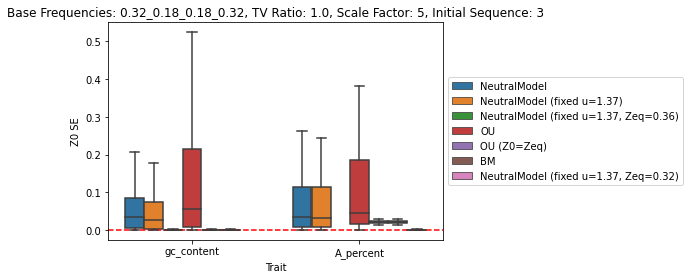

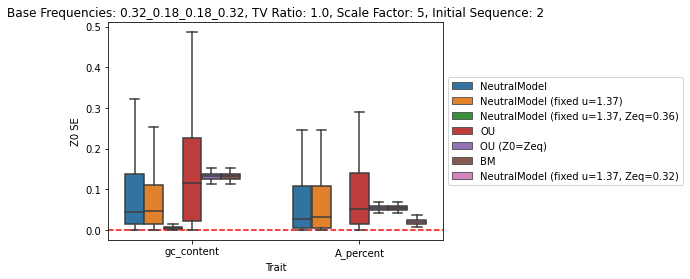

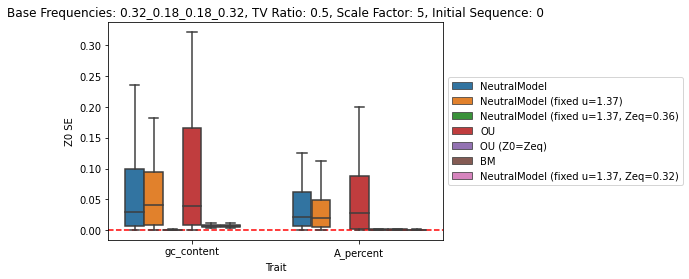

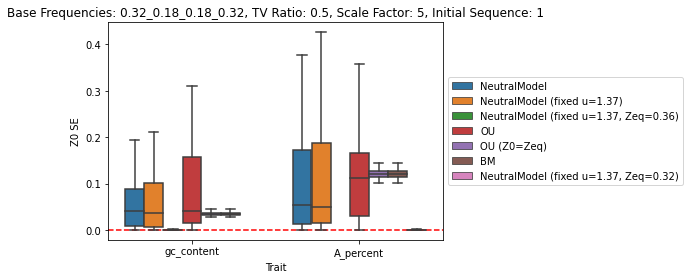

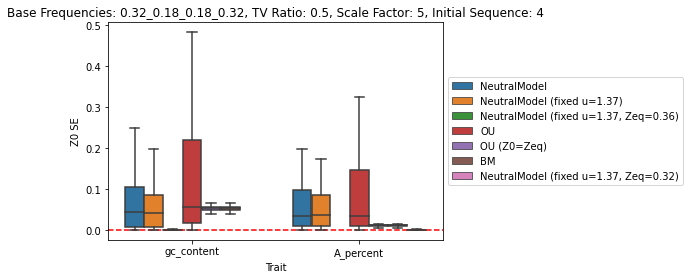

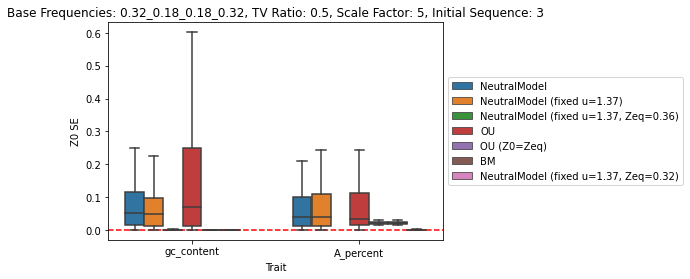

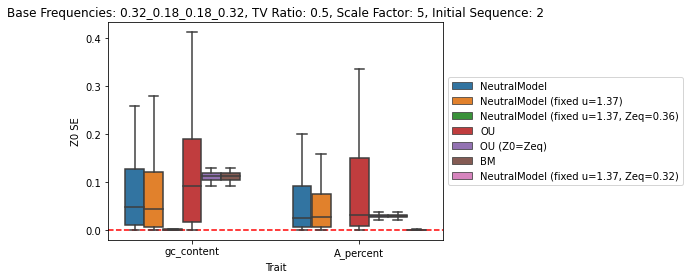

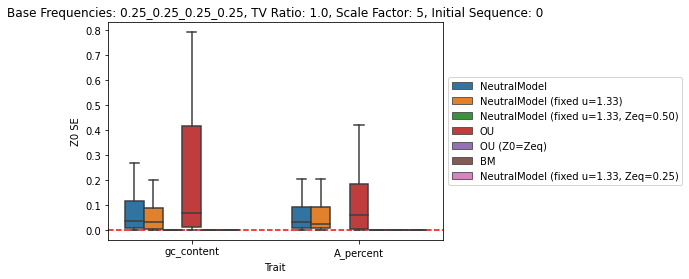

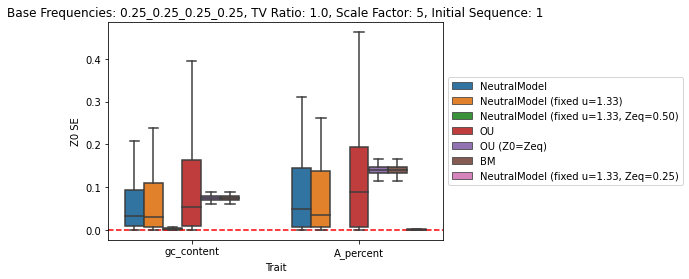

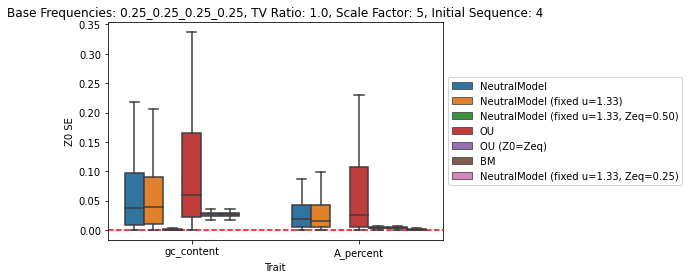

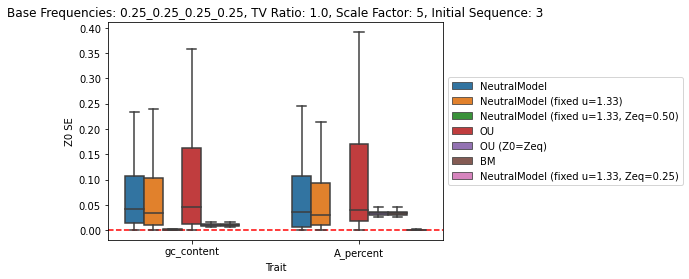

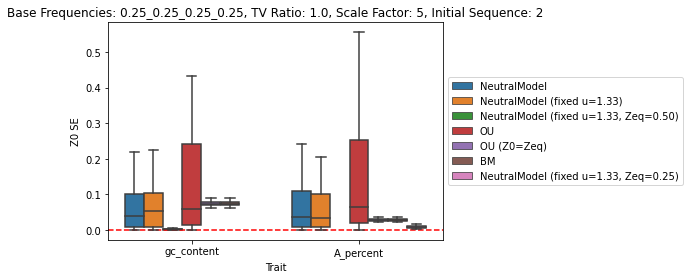

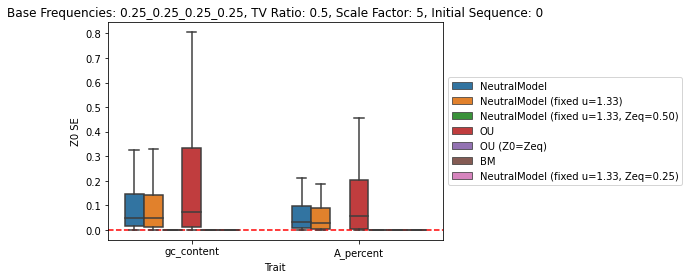

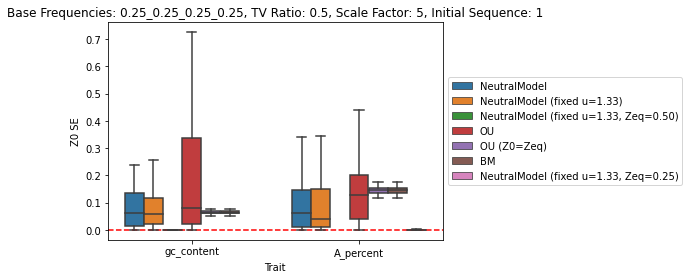

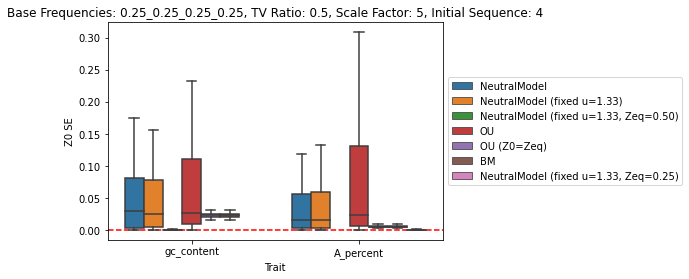

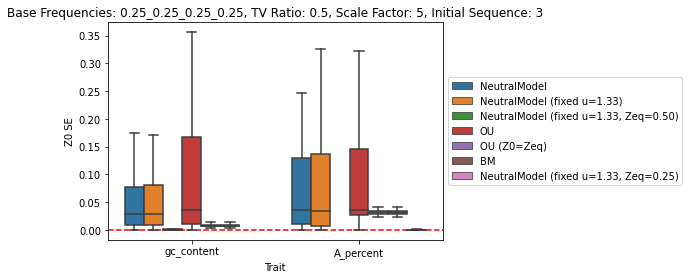

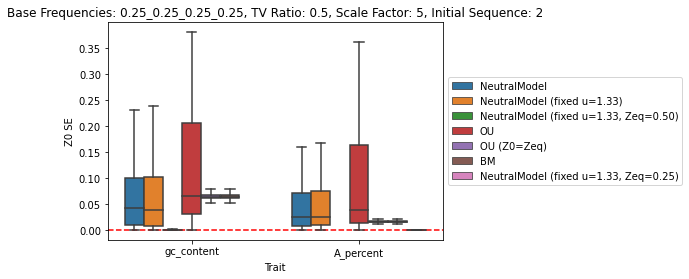

In [583]:
import itertools
for sf, bf, tv, ins in itertools.product(res_df['ScaleFactor'].unique(), res_df['BaseFreq'].unique(), res_df['TVRatio'].unique(), res_df['InitialSequence'].unique()):

    filt_df = res_df.loc[(res_df['ScaleFactor'] == sf) & (res_df['BaseFreq'] == bf) & 
                         (res_df['TVRatio'] == tv) & (res_df['InitialSequence'] == ins) &
                         (res_df['Trait'] != 'gaussian_es_trait')]
    
    ax = sns.boxplot(x="Trait", y='Z0 SE', hue="Model", data=filt_df, showfliers = False)
    plt.axhline(y=0., ls='--', c='r', zorder=1)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(f"Base Frequencies: {bf}, TV Ratio: {tv}, Scale Factor: {sf}, Initial Sequence: {ins}")
    plt.show()

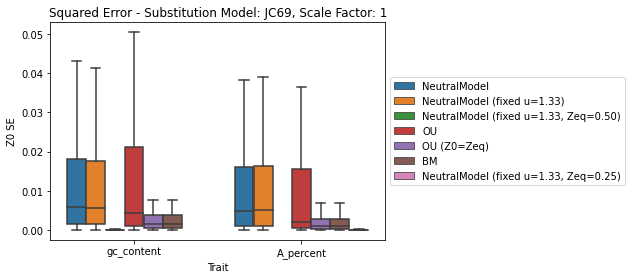

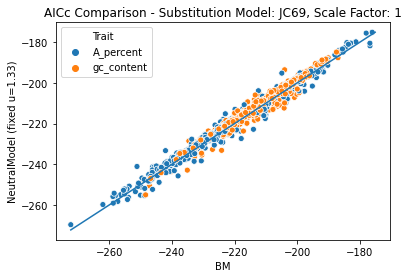

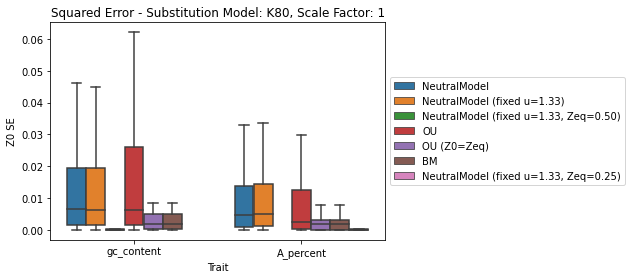

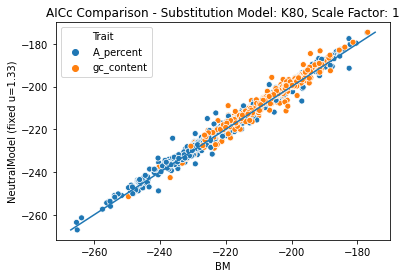

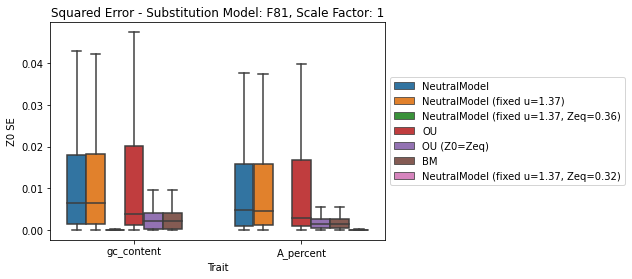

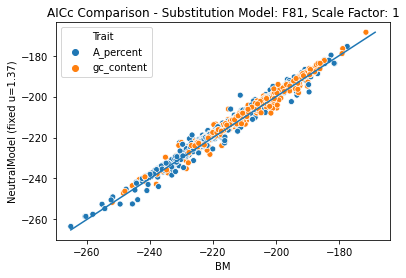

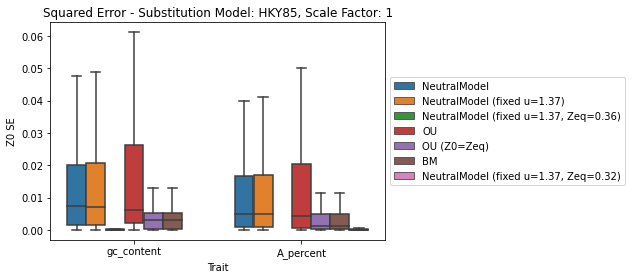

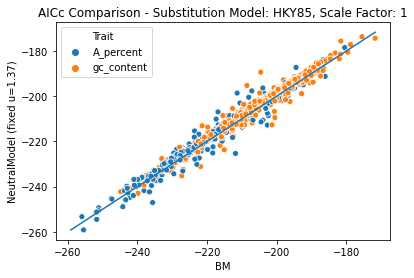

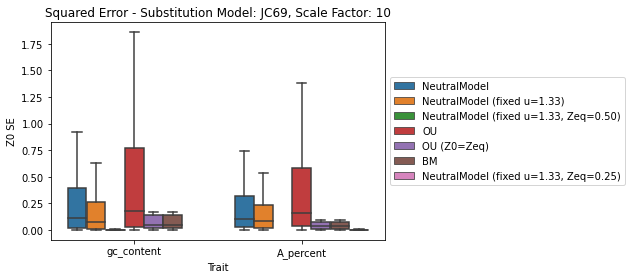

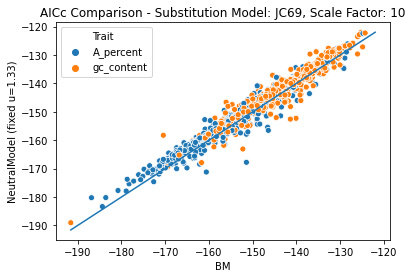

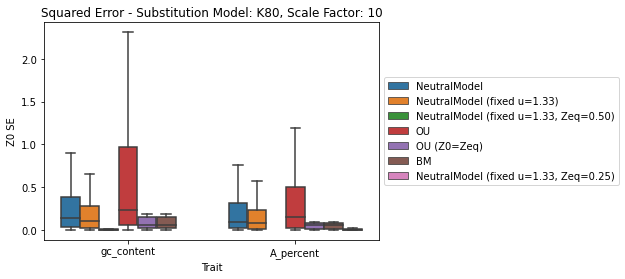

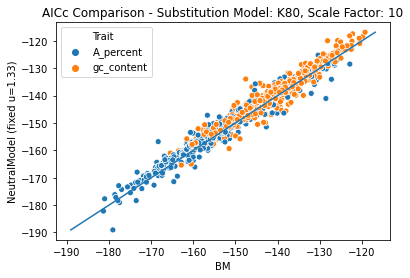

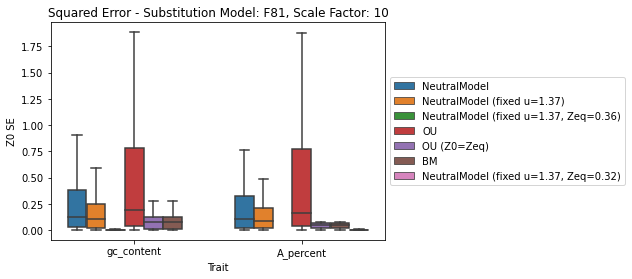

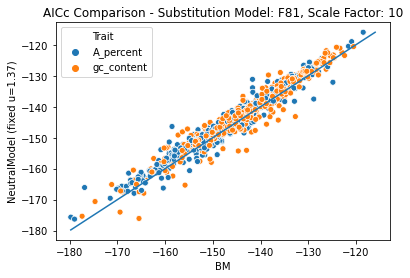

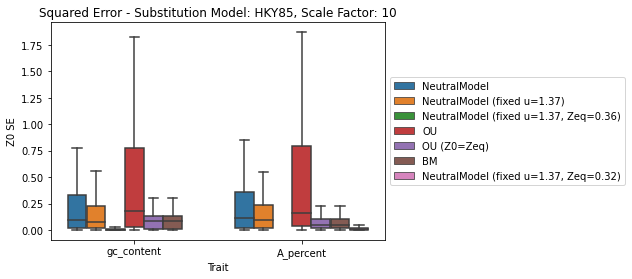

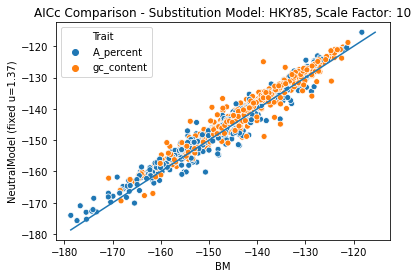

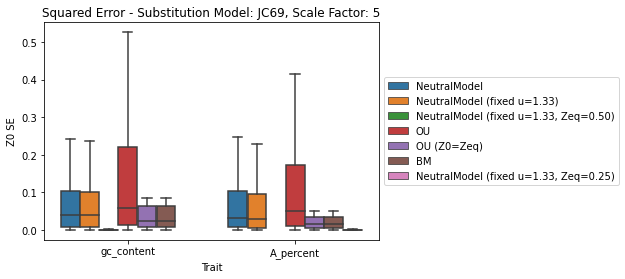

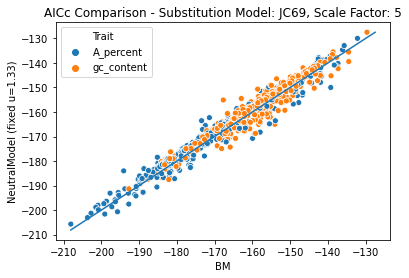

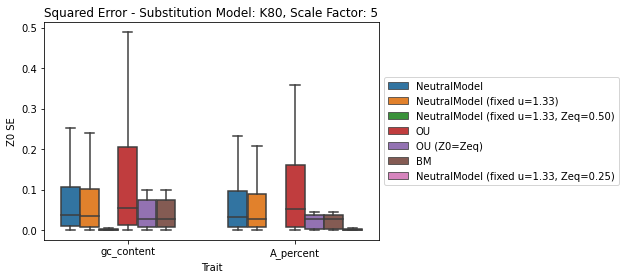

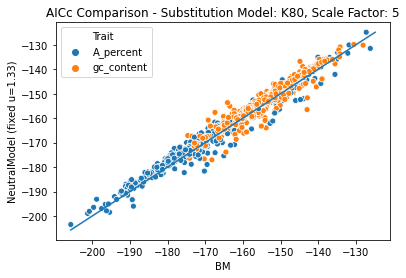

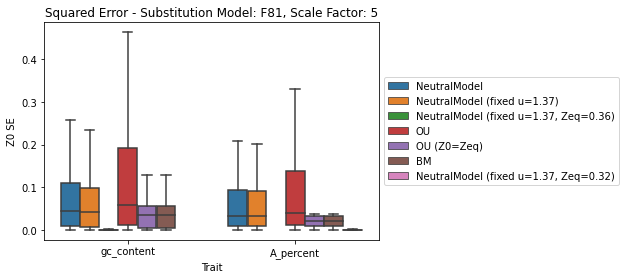

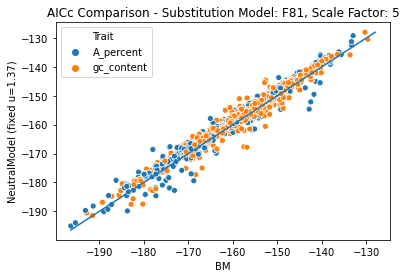

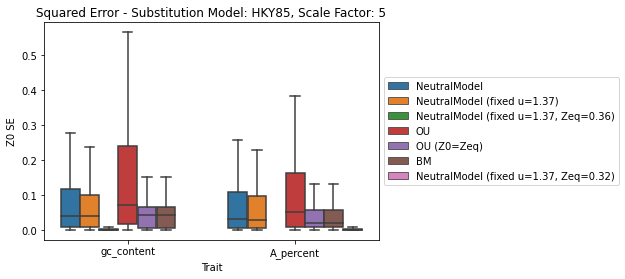

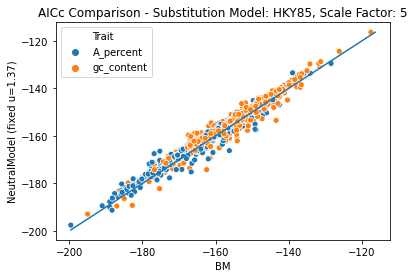

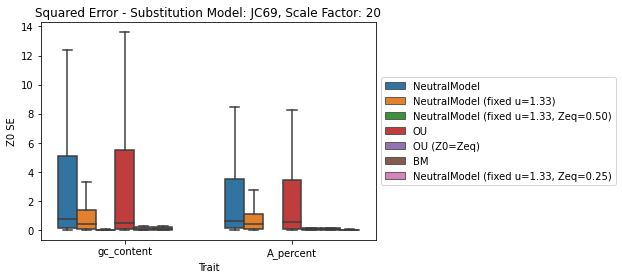

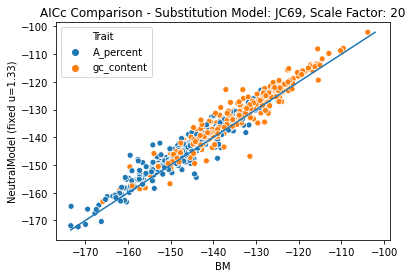

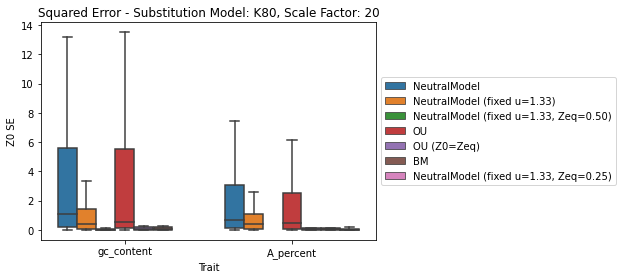

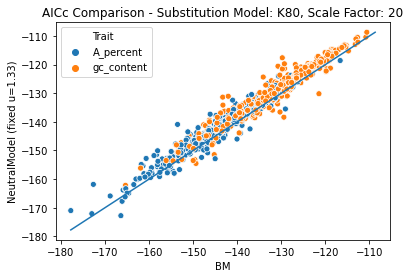

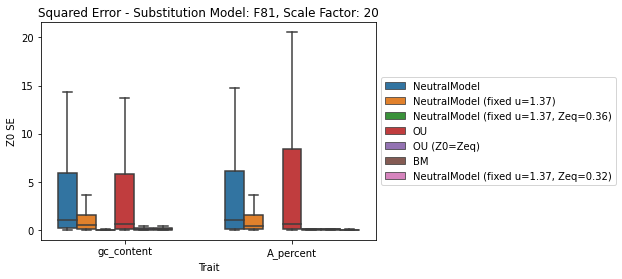

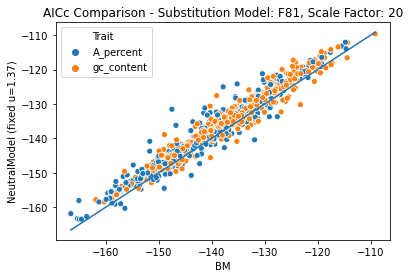

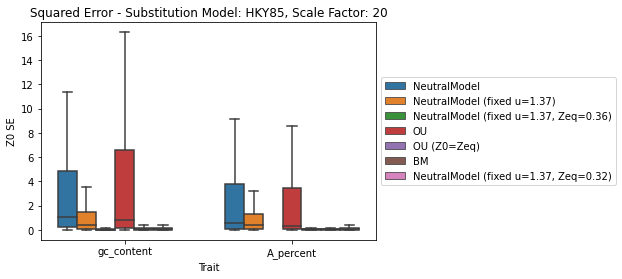

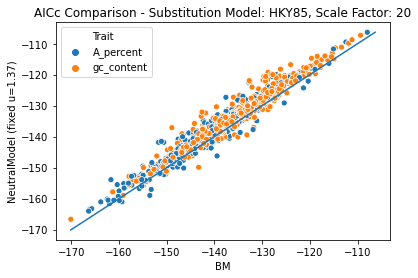

In [650]:
models = {
    'JC69': {
        'BaseFreq': ['0.25_0.25_0.25_0.25'],
        'TVRatio': 0.5
    },
    'K80': {
        'BaseFreq': ['0.25_0.25_0.25_0.25'],
        'TVRatio': 1.0
    },
    'F81': {
        'BaseFreq': ['0.32_0.18_0.18_0.32'],
        'TVRatio': 0.5
    },
    'HKY85': {
        'BaseFreq': ['0.32_0.18_0.18_0.32'],
        'TVRatio': 1.0
    }
}


x = 'BM'


for sf, (m, v) in itertools.product(res_df['ScaleFactor'].unique(), models.items()):

    filt_df = res_df.loc[(res_df['ScaleFactor'] == sf) & (res_df['BaseFreq'].isin(v['BaseFreq'])) & 
                             (res_df['TVRatio'] == v['TVRatio']) &
                             (res_df['Trait'] != 'gaussian_es_trait')]
    
    filt_mdf = filt_df.pivot(index=['BaseFreq','TVRatio','ScaleFactor','InitialSequence', 'Trait', 'Simulation'],
                   columns='Model', values='AICc').reset_index()

    ax = sns.boxplot(x="Trait", y='Z0 SE', hue="Model", data=filt_df, showfliers = False)
    #plt.axhline(y=0., ls='--', c='r', zorder=1)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(f"Squared Error - Substitution Model: {m}, Scale Factor: {sf}")
    plt.show()
    
    if m in ['JC69', 'K80']:
        y = 'NeutralModel (fixed u=1.33)'
    else:
        y = 'NeutralModel (fixed u=1.37)'

    sns.scatterplot(data=filt_mdf, x=x, y=y, hue='Trait')
    lins = np.linspace(filt_mdf[[x, y]].min().min(), filt_mdf[[x, y]].max().max(), 1000)
    plt.plot(lins, lins)
    plt.title(f"AICc Comparison - Substitution Model: {m}, Scale Factor: {sf}")
    plt.show()

In [622]:
data = pd.read_csv("simulation_analysis/data/q_traits/0.28_0.22_0.22_0.28/0.5/1/1/97.csv", index_col=0)
tree = Phylo.read("simulation_analysis/metadata/pruned_mammalian_tree_transformed.nwk", "newick")

In [589]:
nm = NeutralModel(data['gc_content'], tree)
nm.fit()

{'Optimization': {'Success': True,
  'Message': b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'},
 'Loglikelihood': 107.39815226230668,
 'Pairwise divergence loss': 0.0011419118093786216,
 'DOF': 5,
 'AIC': -204.79630452461336,
 'AIC.c': -203.03159864226043,
 'BIC': -196.35190725404368,
 'Parameters': {'Z0': 0.24513095304725335,
  'Zeq': -1.4729189137000354,
  'Psi': 0.00612052239096838,
  'sigma_eq': 0.008034454279554912,
  'u': 1.0044295960750742}}

In [623]:
nm = NeutralModel(data['gc_content'], tree, equilibrium_z0=True)
nm.fit()

{'Optimization': {'Success': True,
  'Message': b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'},
 'Loglikelihood': 108.41146949062123,
 'Pairwise divergence loss': 0.0009232301780496381,
 'DOF': 3,
 'AIC': -210.82293898124246,
 'AIC.c': -210.1562723145758,
 'BIC': -205.75630061890064,
 'Parameters': {'Z0': 0.05664409612434963,
  'sigma_eq': 0.0032595625477825105,
  'u': 1.0000026166374276,
  'Zeq': 0.05664409612434963,
  'Psi': 0.006519125095565021}}

In [624]:
ou = OU(data['gc_content'], tree, equilibrium_z0=True)
ou.fit()

{'Optimization': {'Success': True,
  'Message': b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'},
 'Loglikelihood': 108.45555137801202,
 'Pairwise divergence loss': 0.0009373962827327404,
 'DOF': 3,
 'AIC': -210.91110275602404,
 'AIC.c': -210.24443608935738,
 'BIC': -205.84446439368222,
 'Parameters': {'Zeq': 0.05666889890989734,
  'sigma': 0.006172664436702023,
  'alpha': 0.09999984494854433}}

In [606]:
nm = NeutralModel(data['gc_content'], tree, equilibrium_z0=True, fixed_params={'u': 1.37})
nm.fit()

{'Optimization': {'Success': True,
  'Message': b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'},
 'Loglikelihood': 106.360027885597,
 'Pairwise divergence loss': 0.0011112704661841019,
 'DOF': 2,
 'AIC': -208.720055771194,
 'AIC.c': -208.3957314468697,
 'BIC': -205.34229686296615,
 'Parameters': {'Z0': 0.07208443265542049,
  'sigma_eq': 0.0026927853653949912,
  'u': 1.37,
  'Zeq': 0.07208443265542049,
  'Psi': 0.0053855707307899825}}

In [626]:

data = pd.read_csv("ancient_erv_analysis/data/3_q_traits/2_simulated_sequences/segment_320_722/traits.csv", index_col=0).T
tree = Phylo.read("ancient_erv_analysis/metadata/segment_trees/paml_inferred/segment_320_722.nwk", "newick")

data

gc_content  longest_ORF  A_percent  longest_ORF_alan
ailuropoda_melanoleuca             0.497449     0.331633   0.216837             104.0
aotus_nancymaae                    0.484108     0.212714   0.249389              36.0
canis_familiaris                   0.492347     0.283163   0.244898              62.0
carlito_syrichta                   0.486998     0.212766   0.260047              82.0
cavia_porcellus                    0.474537     0.120370   0.247685              39.0
cebus_capucinus                    0.492718     0.194175   0.247573              74.0
cercocebus_atys                    0.496386     0.207229   0.238554              80.0
chinchilla_lanigera                0.469799     0.234899   0.243848              25.0
chlorocebus_sabaeus                0.501205     0.149398   0.236145              38.0
colobus_angolensis_palliatus       0.495169     0.241546   0.241546              94.0
dipodomys_ordii                    0.500000     0.137931   0.246305              39.0
equus_caballus                     0.533333     0.293827   0.187654              50.0
felis_catus                        0.476427     0.233251   0.253102              19.0
fukomys_damarensis                 0.501188     0.154394   0.225653              43.0
gorilla_gorilla                    0.500000     0.214976   0.253623              74.0
heterocephalus_glaber_male         0.490566     0.176887   0.221698              24.0
homo_sapiens                       0.493797     0.272953   0.260546             104.0
ictidomys_tridecemlineatus         0.490000     0.180000   0.232500              60.0
jaculus_jaculus                    0.445596     0.150259   0.264249              53.0
loxodonta_africana                 0.545673     0.225962   0.213942              50.0
macaca_fascicularis                0.492823     0.208134   0.241627              81.0
macaca_mulatta                     0.495215     0.208134   0.241627              81.0
macaca_nemestrina                  0.491607     0.261391   0.244604             103.0
mandrillus_leucophaeus             0.496386     0.207229   0.238554              80.0
mustela_putorius_furo              0.463104     0.216285   0.249364              59.0
myotis_lucifugus                   0.518987     0.220253   0.217722              25.0
nomascus_leucogenys                0.491525     0.164649   0.251816              50.0
otolemur_garnettii                 0.491184     0.153652   0.251889              51.0
pan_paniscus                       0.492754     0.193237   0.260870              74.0
pan_troglodytes                    0.496386     0.192771   0.260241              67.0
panthera_pardus                    0.487562     0.191542   0.251244              27.0
panthera_tigris_altaica            0.486284     0.192020   0.251870              27.0
propithecus_coquereli              0.493734     0.270677   0.255639              90.0
pteropus_vampyrus                  0.476773     0.163814   0.239609              47.0
rhinopithecus_bieti                0.490338     0.241546   0.241546              94.0
rhinopithecus_roxellana            0.490338     0.241546   0.241546              94.0
saimiri_boliviensis_boliviensis    0.492754     0.193237   0.248792              74.0
sus_scrofa                         0.513514     0.152334   0.213759              45.0

In [627]:
nm = NeutralModel(data['gc_content'], tree)
nm.fit()

{'Optimization': {'Success': True,
  'Message': b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'},
 'Loglikelihood': 117.80773370988976,
 'Pairwise divergence loss': 0.0007661292298238177,
 'DOF': 5,
 'AIC': -225.61546741977952,
 'AIC.c': -223.74046741977952,
 'BIC': -217.4275366211476,
 'Parameters': {'Z0': 0.5603075559785313,
  'Zeq': 0.4299637191431126,
  'Psi': 1e-12,
  'sigma_eq': 0.0018968396674167896,
  'u': 2.0}}

In [633]:
nm = NeutralModel(data['gc_content'], tree, equilibrium_z0=True, fixed_params={'u': 1.34})
nm.fit()

{'Optimization': {'Success': True,
  'Message': b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'},
 'Loglikelihood': 110.10898446892965,
 'Pairwise divergence loss': 0.0010246071140341806,
 'DOF': 2,
 'AIC': -216.2179689378593,
 'AIC.c': -215.87511179500214,
 'BIC': -212.94279661840653,
 'Parameters': {'Z0': 0.5215988073450772,
  'sigma_eq': 0.0016259824813715717,
  'u': 1.34,
  'Zeq': 0.5215988073450772,
  'Psi': 0.0032519649627431434}}

In [629]:
ou = OU(data['gc_content'], tree)
ou.fit()

{'Optimization': {'Success': True,
  'Message': b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'},
 'Loglikelihood': 118.88325838668015,
 'Pairwise divergence loss': 0.0005754366846145623,
 'DOF': 4,
 'AIC': -229.7665167733603,
 'AIC.c': -228.5543955612391,
 'BIC': -223.21617213445478,
 'Parameters': {'Z0': 0.5866789886414611,
  'Zeq': 0.479897229181519,
  'sigma': 0.0045488153537581455,
  'alpha': 7.006815075880198}}

In [630]:
ou = OU(data['gc_content'], tree, equilibrium_z0=True)
ou.fit()

{'Optimization': {'Success': True,
  'Message': b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'},
 'Loglikelihood': 110.48656515586974,
 'Pairwise divergence loss': 0.0011224828389701578,
 'DOF': 3,
 'AIC': -214.97313031173948,
 'AIC.c': -214.2672479587983,
 'BIC': -210.06037183256032,
 'Parameters': {'Zeq': 0.5325383727251455,
  'sigma': 0.0037113828088663745,
  'alpha': 0.0999719314771595}}